Installation of the open3d library. You need to restart the environment after the installation.

In [ ]:
!pip install open3d==0.13.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
from glob import glob
from google.colab import files
import time

import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
import keras

from keras.layers import Dense, TimeDistributed, LSTM, Add, Input, concatenate, Concatenate, Lambda, Flatten, Conv2D, ZeroPadding2D, Dropout #togliere ciò che non serve
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import keras.backend as K
from tensorflow.keras.utils import Sequence

import open3d as o3d



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Before starting, we want to do a brief operative explanation.

All the project have been done with Jupyter notebook on a local computer and then it was loaded on Colab. This have been done only for efficiency reasons, since the free version of Colab is too slow.
The models have been trained on a PC with the following characteristics:


*   CPU AMD Ryzen 9 3900X
*   RAM 32GB
*   GPU Nvidia RTX 3080

Some code cells haven't been reported in this Colab, such as some cells for the dataset creation (image resizing, point cloud registration) since it requires original data, while we have uploaded in Google Drive the ready to use dataset for saving storage space (already resized images for example). In this way you can directly load the ready to use datasets.

The Colab is divided in six parts. The first part is an introduction to visual odometry problem. The successive three parts correspond to the three deep learning experiments explained in detail in the respective sections, while the fifth part is a comparison between our deep learning results and traditional methods to compute visual odometry. At the end we made a brief summary of our considerations and what we learned with this project.

The Colab is structured to make each section completely executable, for this reason some code cells are repeated inside different sections. Text cells are not repeated instead, so the reading of the text cells in order is preparatory to the following ones.

As said before, Google Colab is really slow in loading datasets, computing results, training the networks, so we saved all these things in order to load them when needed. Our advice is to skip the execution of code cells to compute these stuff and execute directly the cells to load them.



# **Introduction**

In this project we tried to apply Deep Learning techniques, studied in the Deep Learning course, to the visual odometry problem.

## **Visual odometry**

The word "Odometry" derives from two greek words: "odos" which means *route* and "metron" which means *measure*, thus it's the measure of the route.

There exist serveral different types of odometry. We refer to visual odometry to indicate a type of odometry based on images.

In computer science and robotics, visual odometry is used to compute the path done by the camera that acquires the images and therefore of the robot which is equipped with it.

Visual odometry can be classified in three different ways, depending on the type of camera used:


*   *monocular visual odometry*, if a monocular camera is used, that captures only a single RGB flow;

*   *stereo visual odometry*, if a stereo camera is used, that captures two RGB flows, in order to reproduce a binocular vision;

*   *RGBD visual odometry*, if a depth camera is used. It captures RGB monocular images and has a laser emitter and a laser receiver, so it can calculate the depth of the scene basing on the time of flight of the laser impulse.


**Monocular images**

A single RGB image flow is used.

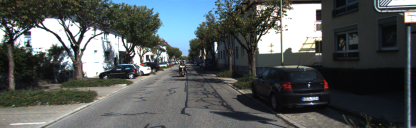

**Stereo images**

A flow of paired images is used: left and right.

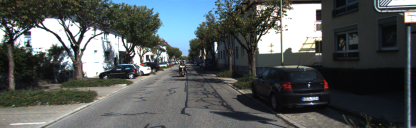 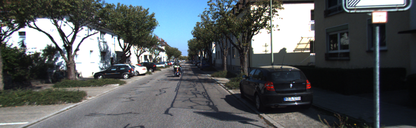

**RGBD images**

RGBD means RGB-Depth, so a flow of paired images is used: RGB images and depth images. The second ones are 16bit single-channel images. Depending on the camera used, the 16-bit values can have different scales. In this example, each value in the depth image represents the distance in millimeters from obstacles.

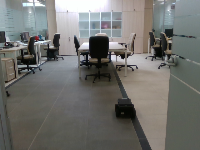 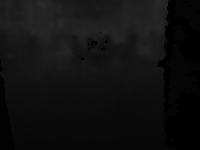

## **Mathematical formalization**

### **Robot pose**

The pose of a robot in the three dimensions at any discrete time can be described as a *Special Euclidean group* (SE3).

A Special Euclidean group is composed by a *Special Orthogonal group*, that is a rotation matrix, and a *translation vector*.

They respectively describe the **orientation** and the **position** of the robot, at any discrete time instant. We refer to the **pose** to indicate the position and the orientation of the robot.

**Special Orthogonal group**

$SO(3) = \{\mathbf{R} \in \mathbb{R}^{3 \times 3}|\mathbf{R}\mathbf{R}^{T} = \mathbf{I}, det(\mathbf{R}) = 1\}$

**Special Euclidean group**

$SE(3)\ = \Big\{\mathbf{T} = {\begin{bmatrix}
\mathbf{R} & \mathbf{t}\\
\mathbf{0}^{T} & 1
\end{bmatrix}} \in \mathbb{R}^{4 \times 4}|\mathbf{R} \in  SO(3), \mathbf{t} \in \mathbb{R}^{3}  \Big\}$

$\mathbf{T}$ is called *transformation matrix*.

**Initial pose**

Typically the initial pose is set to the origin of the axes, with an initial rotation that is the identity matrix.

$\mathbf{t} = (0, 0, 0)$

$\mathbf{R} = \mathbf{I} \in \mathbb{R}^{3 \times 3}$

**Pose updating**

At any discrete time, the new pose of the robot is computed concatenating the previous one with the SE3 group which represents the relative rotation and translation performed by the robot at that time step.

Given a pose represented by $\mathbf{R}_{pose}$ and $\mathbf{t}_{pose}$ and a relative transformation $\mathbf{R}_{relative}$ and  $\mathbf{t}_{relative}$ the new pose can be computed as follow:

$\mathbf{t}_{new} = \mathbf{t}_{pose} + (\mathbf{R}_{pose} \cdot \mathbf{t}_{relative})$

$\mathbf{R}_{new} = \mathbf{R}_{relative} \cdot \mathbf{R}_{pose} $

**Brief rotations hints**

A rotation in the 3D space can be described in several ways. The three most common ways are:


1.   *rotation matrix*, the SO3 group explained before;
2.   *quaternion*, an extension of the complex numbers $\mathbb{C}$, typically represented as a vector of four elements $q_x, q_y, q_z, q_w$;
3.   *Euler angles*, a vector of three elements, which represent the rotations along the $x, y$ and $z$ axes.

Each of these representations can be converted into another.




### **Metrics**

Several different metrics exist in order to evaluate a visual odometry algorithm. The most common ones are the *relative pose error* (RPE) and the  *absolute trajectory error* (ATE). In our project we used the ATE to evaluate our model, because it measures the global consistency of the estimated trajectory.

**ATE**

The global consistency can be evaluated by comparing the absolute distances between the estimated and the ground truth trajectory. It is the root mean squared error over all time indices of the translational components.

$RMSE(\mathbf{F}_{1:n}) = \bigg({1 \over n}\sum_{k = 1}^n||trans(\mathbf{F}_{k})||^2\bigg)^{1 / 2}$

where $\mathbf{F}_{k}$ is the absolute trajectory error at timestep $k$.

In the following, to clearify what ATE is, an image is showed.

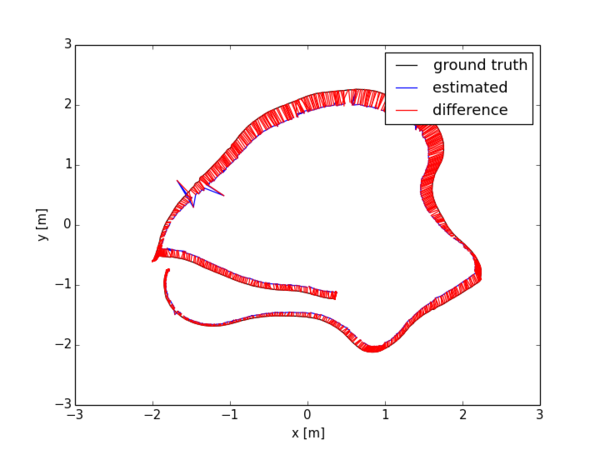

The red lines represent the distance between each point in the estimated trajectory and the corresponding point in the ground truth.

The ATE is the mean squared error of these distances.

# **TransformationNet**

The first experiment we made was about **supervised** monocular visual odometry. We tried to train a deep neural network to make it learn the relative transformation perfomed by the camera between two frames. Our contribution in this experiment is the idea of learn the relative transformation instead of the true pose directly. In literature, similar neural network are trained, but they are equipped with LSTM or GRU in order to maintain a long term memory, to learn the pose directly given a sequence of images. Learning the relative transformation between two frames allow us to avoid these types of architecture, relying on a leaner architecture. 
Furthermore, learning the relative transformation could be useful in real time applications, where images are acquired as a stream of data, so at each time step a new image is available and we can calculate the new pose, given the previous pose and the relative transformation predicted by the network.

Given two successive frames and the ground truth poses, represented as $(\mathbf{R}_1, \mathbf{t}_1)$ and $(\mathbf{R}_2, \mathbf{t}_2)$ respectively, it is possible to calculate the relative transformation between the to poses as follow:

$\mathbf{R}_{relative} = \mathbf{R}_1^{-1} \cdot \mathbf{R}_2$

$\mathbf{t}_{relative} = \mathbf{R}_1^{-1} \cdot (\mathbf{t}_2 - \mathbf{t}_1)$

In the following an image is used to clearify this network. Two successive images with 3 channels are concatenate to obtain a 6 channels tensor. This 6 channels tensor is given in input to the network and the network has to predict the relative transformation between the two 3 channels images that make up the 6 channels tensor. The idea is to use a convolutional neural network to extract salient features from images and then use dense layers to regress the transformation.

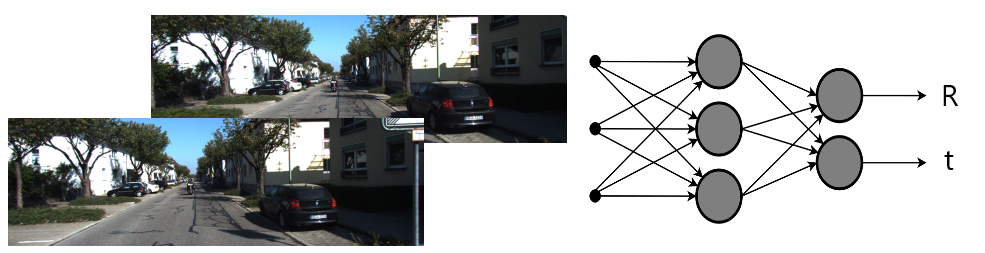

## **Kitti dataset**

The dataset used for this experiment is the Kitti dataset (http://www.cvlibs.net/datasets/kitti/eval_odometry.php). It's a street stereo images dataset. Since the aim is to learn visual odometry from monocular images, only the left-most camera images are used.

Original images are of the size 1241 x 376, but for our purpose we resized them at dimension 416 x 128.


This is an example of Kitti stereo images.

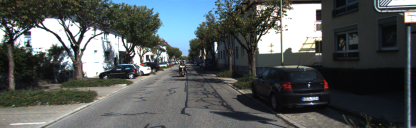 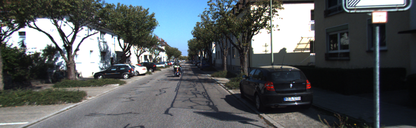

The dataset is composed by 22 sequences, the first 11 are labeled with the ground truth poses, while the second 11 are unlabeled, as testing sequences. In order to train and evaluate our network, the ground truth is required, so we used only the first 11 sequences, splitted as follow:

*   sequences **00** (4541 images), **02** (4661 images), **05** (2761 images) and **08** (4071 images) are the longest ones, so we used them for the **training set**
*   sequence **01** (1101 images), **06** (1101 images) and **07** (1101 images) that contain the same number of images for the **validation set**
*   sequence **03** (801 images), **04** (271 images), **09** (1591 images), **10** (1201 images) for the **test set**

In [ ]:
root_path = "/content/drive/MyDrive/kitti_dataset/sequences/"

train_sequences = ["00", "02", "05", "08"]

val_sequences = ["01", "06", "07"]

test_sequences = ["03", "04", "09", "10"]

kitti_sequences = ["00",
                   "01",
                   "02",
                   "03",
                   "04",
                   "05",
                   "06",
                   "07",
                   "08",
                   "09",
                   "10"]

### **The frame of reference**

To understand how the pose of the camera is calculated, we need to explain the camera frame reference. 

Depending on the camera used, the coordinate system can change. A very common system, that is used by the cameras of Kitti dataset too, is represented in the figure below. The $z$-axis is the axis that goes out from the front of camera, the $x$-axis is perpendicular and coplanar to $z$ and grows moving on the right, the $y$-axis is orthogonal to the previous ones and grows moving on down.

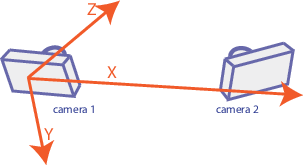


### **Ground truth**

In this experiment, not only the ground truth of the poses is needed, but also the ground truth of the relative transformations.

In the *kitti_dataset* folder, for each sequence, there are two ground truth files:



*   {*number of the sequence*}_path.npy, that is a numpy file that contains all the ground truth of the camera poses. The poses here are expressed as a transformation matrix (without the last row, which is composed only of zeros and ones), so the rotations are expressed as a rotation matrix $\mathbf{R}$. In fact, to calculate the ATE error the rotation matrix is required; 
*   {*number of the sequence*}_rt.npy, that is a numpy file that contains all the ground truth of the relative transformations, calculated as explained in the previous formula. Here the relative transformations are expressed as Euler angles, because we want the network to learn this type of rotation.

**Why Euler angles**

In literature, deep neural networks are trained to predict rotations as Euler angles for two reasons:


1.   the network must learn to predict less parameters, in fact Euler angles can be seen as an output vector of three elements, while a quaternion is a vector of four elements and a rotation matrix a vector of nine elements;
2.   Euler angles have an higher level semantic meaning, in fact the values are directly the angles in radiants of the rotations along the three axes.

The only limitation of Euler angles is that they lack of a *degree of freedom*, because three parameters aren't enough to describe a 3D rotation. It's necessary to define a rotation order along the axes, because, for example, a rotation along the $z$-axis and then along the $y$-axis will lead to a different result than a rotation along the $y$-axis and then a rotation along the $z$-axis (this is known as the **gimbal lock**). You can figure it out using the thumb, the index and the middle finger of your right hand as the three orthogonal axes.

It's not important the order defined, it's important to use always the same order for all the transformations. We used the *zyx* order: first the rotation is performed along the $z$-axis, then along the $y$-axis, and finally along the $x$-axis.







A *yaw* is a counterclockwise rotation of $\alpha$ about the $z$-axis.

$\mathbf{R}_z(\alpha) = \begin{pmatrix} \cos(\alpha) & -\sin(\alpha) & 0 \\ \sin(\alpha) & \cos(\alpha) & 0 \\ 0 & 0 & 1\end{pmatrix}$

A *pitch* is a counterclockwise rotation of $\beta$ about the $y$-axis.

$\mathbf{R}_y(\beta) = \begin{pmatrix} \cos(\beta) & 0 & \sin(\beta) \\ 0 & 1 & 0 \\  -\sin(\beta) & 0 & \cos(\beta)\end{pmatrix}$

A *roll* is a counterclockwise rotation of $\gamma$ about the $x$-axis.

$\mathbf{R}_x(\gamma) = \begin{pmatrix} 1 & 0 & 0 \\ 0 & \cos(\gamma) & -\sin(\gamma) \\ 0 & \sin(\gamma) & \cos(\gamma)\end{pmatrix}$

The final rotation matrix is calculated as the dot product of these three matrix.

$\mathbf{R}(\alpha, \beta, \gamma) = \mathbf{R}_z(\alpha) \cdot \mathbf{R}_y(\beta) \cdot \mathbf{R}_x(\gamma)$



In the following cell, we defined a function to convert from Euler angles to rotation matrix. This function will be used in the ATE calculation.

In [ ]:
def euler_to_matrix(euler): #euler is a vector in the form [yaw, pitch, roll] (because the ground truth is in the zyx order)
    yaw = euler[0]
    pitch = euler[1]
    roll = euler[2]
    R_z = tf.stack([tf.stack([tf.math.cos(yaw), -tf.math.sin(yaw), 0.0]), tf.stack([tf.math.sin(yaw), tf.math.cos(yaw), 0.0]), tf.stack([0.0, 0.0, 1.0])])
    R_y = tf.stack([tf.stack([tf.math.cos(pitch), 0.0, tf.math.sin(pitch)]), tf.stack([0.0, 1.0, 0.0]), tf.stack([-tf.math.sin(pitch), 0.0, tf.math.cos(pitch)])])
    R_x = tf.stack([tf.stack([1.0, 0.0, 0.0]), tf.stack([0.0, tf.math.cos(roll), -tf.math.sin(roll)]), tf.stack([0.0, tf.math.sin(roll), tf.math.cos(roll)])])
    
    R = K.dot(K.dot(R_z, R_y), R_x)
    
    return R

In the following cells is shown the poses and the relative transformations ground truth for the first element of the sequence 00.

In [ ]:
ground_truth_pose_00 = np.load(root_path + "00/00_path.npy")
ground_truth_rt_00 = np.load(root_path + "00/00_rt.npy")

T_matrix_0 = np.reshape(ground_truth_pose_00[0], (3, 4))
print("Transformation matrix of the first pose of the sequence 00: \n", T_matrix_0, "\n")

R_matrix_0 = T_matrix_0[:, :3] #It's the identity
t_0 = T_matrix_0[:, -1] #It's the origin

print("Orientation of the first pose of the sequence 00: \n", R_matrix_0, "\n")
print("Position of the first pose of the sequence 00: \n", t_0, "\n")

T_matrix_1 = np.reshape(ground_truth_pose_00[1], (3, 4))
print("Transformation matrix of the second pose of the sequence 00: \n", T_matrix_1, "\n")

rt_0 = ground_truth_rt_00[0]
print("Relative transformation between the two poses (in the form [yaw, pitch, roll, x, y, z]):\n", rt_0)

To show that the formula expressed in the **pose updating** section works well, we try to apply it below.
The rotation and the translation obtained by applying the relative transformation to the first pose, are exactly the same of the second pose of the previous cell.

In [ ]:
t_new = t_0 + (np.dot(R_matrix_0, rt_0[3:]))
R_new = np.dot(euler_to_matrix(rt_0[:3]), R_matrix_0)

print("New orientation: \n", R_new)
print("New position: \n", t_new)

### **The Kitti sequences**

It is also possible to plot the paths of the Kitti sequences. Tipically the path considered is the 2D path, so we plot the poses as points in a plane with two coordinates: $x$-coordinate and $z$-coordinate, while the vertical dimension $y$ is omitted.

In [ ]:
n_rows = 3
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,13))
for i in range(n_rows):
    for j in range(n_cols):
        seq_number = i * n_cols + j
        if(seq_number < 11):
            seq_path = root_path + kitti_sequences[seq_number] + "/"
            gt = np.load(seq_path + kitti_sequences[seq_number] + "_path.npy")
            ax[i, j].scatter(gt[:, 3], gt[:, 11], s = 0.2, color='green')

In the following we show the first five images of the sequence 00, and the relative ground truth poses.

In [ ]:
n_rows = 5
n_cols = 1

fig = plt.figure(figsize=(30,15))
for i in range(1, n_rows + 1):
  fig.add_subplot(n_rows, n_cols, i)
  path = root_path + "00/rgb/00000" + str(i) + ".png"
  image = np.asarray(load_img(path)) / 255
  plt.imshow(image)

It is possible to notice that as the movement is quite straight in the $z$-axis direction, the $z$-axis values increment more rapidly over time than the $x$-axis and $y$-axis values (it's the right-down-most value in the matrix).

In [ ]:
ground_truth = np.load(root_path + "00/00_path.npy")
for i, pose in enumerate(ground_truth[:5]):
  print("Pose at time %d:" % i)
  print(np.reshape(pose, (3, 4)))

## **ATE metric**

We defined a function for calculating ATE metric, that has already been explained.

It takes two parameters:


1.   transformation_predicted is a tuple of the form (rotations_batch, translations_batch), which contains all the relative rotations and translations predicted by the network for a batch
2.   pose_true, that is the ground truth, it's a tuple of the form (true_relative_transformations_batch, previous_true_pose_batch, next_true_pose_batch).

So if we have a sequence of $n$ images, we can calculate the ATE as follow:
- the initial previous pose is the first pose in previous_true_pose_batch of the pose_true tuple
- then we iterate over all the $i$ elements of the sequence
  - we can calculate the next pose using the pose updating formula, using the previous pose and the $i$-th relative transformation in transformation_predicted
  - the euclidean distance between the new pose calculated and the $i$-th ground truth pose in pose_true is computed and added to the cumulative error
  - the previous pose is set to the new pose computed using the predicted relative transformation
- the total error is divided by the number of elements in order to obtain the mean and the squared root is computed, so we have the RMSE.

It returns the ATE and the rotations and the translations estimated (that are the orientations and the positions of the camera), starting from the first one. It allow us to plot the estimated trajectory for test sequences.




In [ ]:
def ATE(transformation_predicted, pose_true):
  ATE = 0.0
  translations = []
  rotations = []
 
  previous_pose = tf.reshape(pose_true[1][0], (3, 4)) #initial pose of the batch
  previous_rotation = previous_pose[:, :3] #initial rotation of the batch
  previous_translation = tf.expand_dims(previous_pose[:, -1], axis=1) #initial translation of the batch

  translations.append(previous_translation)
  rotations.append(previous_rotation)

  sequence_length = tf.shape(transformation_predicted[0])[0] #length of the image sequence
  for i in range(sequence_length):
    rotation_predicted = euler_to_matrix(transformation_predicted[0][i]) #predicted relative rotation
    translation_predicted = tf.reshape(transformation_predicted[1][i], (3, 1)) #predicted relative translation
 
    next_pose = tf.reshape(pose_true[2][i], (3, 4)) #next pose true
    next_rotation = next_pose[:, :3] #next rotation true
    next_translation = tf.expand_dims(next_pose[:, -1], axis=1) #next translation true
             
    next_translation_predicted = previous_translation + K.dot(previous_rotation, translation_predicted) #t_new = t_pose + R_pose * t_relative
    next_rotation_predicted = K.dot(rotation_predicted, previous_rotation) # R_new = R_relative * R_pose

    translations.append(next_translation_predicted)
    rotations.append(next_rotation_predicted)

    ATE = ATE + K.sqrt(K.sum(K.square(next_translation - next_translation_predicted))) #euclidean distance

    #the previous pose is set to the new pose predicted
    previous_rotation = next_rotation_predicted
    previous_translation = next_translation_predicted
    
  ATE = K.sqrt(ATE / tf.cast(sequence_length, tf.float32)) #root mean squared error
  return ATE, translations, rotations

## **Training**

In order to train a neural network for this problem and have more customization capabilities, we decided to use low-level Keras functionalities.

### **Datasets creation**

The datasets are manually created, because they differ according to whether they are training, validation or test set.

The **training set** is a set of batches, each batch contains *batch_size* images. The 6 channels tensors obtained by the concatenation of two successive frames are shuffled randomly, then grouped into batches and at the end of each epoch the tensors are shuffled again. This is done to force the convolutional layers to learn more robust features and to avoid the network to adapt itself too well to the same sequence of images in a batch.

The **validation set** is a set of batches, but in this case tensors aren't shuffled, because we want to calculate the ATE metric. In fact, ATE metric isn't used for the training set, but only for the validation and test sets.
To calculate a consistent ATE, the images must be sorted.

The **test set** is made up by Kitti sequences as they are. The images are sorted and not grouped into batches. A batch is the single Kitti sequence. In this way, we can calcuate the ATE on the entire Kitti sequences of the test set.

We used a *batch_size* of 256.

In [ ]:
batch_size = 256

With the next cell, we defined a function that create a list of tuples, containing the paths of the images at time $t$ and $t+1$ and the respective ground truth, with relative transformation, pose at time $t$ and pose at time $t+1$. If the parameter *training* is True, the list is shuffled. Then, tuples are grouped into batches, each batch has exactly the size of *batch_size*.

In [ ]:
def build_dataset(sequences, batch_size=batch_size, training=True):
  dataset = []

  for seq_number in sequences:
    seq_path = root_path + seq_number + "/"
    img_path = seq_path + "rgb/"
    sequence_paths = [img_path + name for name in os.listdir(img_path)]
    sequence_paths.sort()
    rt_ground_truth = np.load(seq_path + seq_number + "_rt.npy")
    pose_ground_truth = np.load(seq_path + seq_number + "_path.npy")
    for index in range(len(sequence_paths) - 1):
        dataset.append((sequence_paths[index], sequence_paths[index + 1], rt_ground_truth[index], pose_ground_truth[index], pose_ground_truth[index + 1]))
  if training:
    np.random.shuffle(dataset)
  seq_size = (len(dataset) // batch_size) * batch_size
  dataset = [x for index, x in enumerate(dataset) if index < seq_size]      
  return dataset

The next function is used to build sequences for the test set. Only the ground truth poses are used here, the relative transformations are not useful.

In [ ]:
def build_test_sequence(sequence):
  dataset = []

  seq_path = root_path + sequence + "/"
  img_path = seq_path + "rgb/"
  sequence_paths = [img_path + name for name in os.listdir(img_path)]
  sequence_paths.sort()
  pose_ground_truth = np.load(seq_path + sequence + "_path.npy")
  for index in range(len(sequence_paths) - 1):
    dataset.append((sequence_paths[index], sequence_paths[index + 1], pose_ground_truth[index], pose_ground_truth[index + 1]))
  return dataset

In [ ]:
train_dataset = build_dataset(train_sequences)
val_dataset = build_dataset(val_sequences, training=False)
test_dataset = [build_test_sequence(sequence) for sequence in test_sequences]

The next two cells define what we called sequence generators (but it's not a python generator strictly). The first one defines train and validation sequences, that are batched, the second one defines test sequences, that are not batched.

They extend the Tensorflow class Sequence, that implements several methods such as **__len__** and **__getitem__** that make our generators iterables.

These classes are used to load the dataset in a lazy way, batch by batch.

In [ ]:
class SequenceGenerator(Sequence):
  def __init__(self,
               dataset, #a list of tuple of the form (current_image, next_image, relative_transformation, previous_pose, next_pose)
               batch_size=batch_size,
               shuffle=True
               ):
    self.dataset = dataset
    self.batch_size=batch_size
    self.len = len(self.dataset) // self.batch_size #number of batches
    self.shuffle = shuffle

  def __len__(self):
    return self.len

  #return the index-th batch
  def __getitem__(self, index):
    image_batch = [] #batch of image at time t and at time t+1 concatenated
        
    relative_transformations_batch = []
    previous_poses_batch = []
    next_poses_batch = []
    for i in range(index * self.batch_size, (index + 1) * self.batch_size): # for n elem in batch_size
      image1 = np.asarray(load_img(self.dataset[i][0])) / 255 #current_image
      image2 = np.asarray(load_img(self.dataset[i][1])) / 255 #next_image
      image = np.concatenate((image1, image2), axis = 2) #image with 6 channel
      image_batch.append(image)
           
      relative_transformations_batch.append(self.dataset[i][2])
      previous_poses_batch.append(self.dataset[i][3])
      next_poses_batch.append(self.dataset[i][4])
                
    return np.array(image_batch), (np.array(relative_transformations_batch, dtype=np.float32), np.array(previous_poses_batch, dtype=np.float32), np.array(next_poses_batch, dtype=np.float32))
    
  #shuffle the dataset
  def on_epoch_end(self):
    if self.shuffle == True:
      np.random.shuffle(self.dataset)

For the test sequences, we don't want to iterate over them, but we want the entire sequence directly.

In [ ]:
class TestSequenceGenerator(Sequence):
  def __init__(self,
               dataset
               ):
    self.dataset = dataset

  def get_sequence(self):
    image_seq = []
    previous_pose_seq = []
    next_pose_seq = []
    for i in range(len(self.dataset)):
      image1 = np.asarray(load_img(self.dataset[i][0])) / 255
      image2 = np.asarray(load_img(self.dataset[i][1])) / 255
      image = np.concatenate((image1, image2), axis = 2)
            
      previous_pose = self.dataset[i][2]
      next_pose = self.dataset[i][3]
      image_seq.append(image)
            
      previous_pose_seq.append(previous_pose)
      next_pose_seq.append(next_pose)
    return np.array(image_seq), (np.array([]), np.array(previous_pose_seq, dtype=np.float32), np.array(next_pose_seq, dtype=np.float32))

In [ ]:
train_generator = SequenceGenerator(train_dataset)
val_generator = SequenceGenerator(val_dataset)

test_generators = [TestSequenceGenerator(sequence) for sequence in test_dataset]

In the following we show how the dataset is composed inside our *train_generator*.

In [ ]:
x, y = train_generator[0] #first batch

In [ ]:
plt.imshow(x[0][:, :, :3])

In [ ]:
plt.imshow(x[0][:, :, 3:])

In [ ]:
print("Pose at time 0: ")
print(y[1][0])

print("Pose at time 1: ")
print(y[2][0])

print("Relative transformation between the two poses: ")
print(y[0][0])

The images in batch are shuffled. The second tensor of the batch is composed by two images that are not the successive of the first two.

In [ ]:
plt.imshow(x[1][:, :, :3])

In [ ]:
plt.imshow(x[1][:, :, 3:])

### **Loss function**

As loss function we used a composed loss function. In fact we divided the rotation loss from the translation loss. Rotations are more difficult to learn than translations, so we introduced a weight to give more importance to the rotation loss. We used 100 as default value for the rotations weight. 

Both the losses are the mean of the L2 norm between the predicted relative transformations and the ground truth.
We tried to use the MSE (that is the same formula without the square root), but we saw that the training is less stable and there is an overfitting condition since the first epochs.

We think this behaviour depends on the fact that the values to predict are all very close to 0. The network tends to learn all values close to 0 even if they are not the correct values and the error is still very low. With the square root, an error < 1 becomes greater, so the network is pushed to learn more correct values.

In [ ]:
def translation_loss(translations_predicted, pose_true):
  return K.mean(K.sqrt(K.sum(K.square(translations_predicted - pose_true[0][:, 3:]), axis=1)))

In [ ]:
def rotation_loss(rotations_predicted, pose_true):
  return K.mean(K.sqrt(K.sum(K.square(rotations_predicted - pose_true[0][:, :3]), axis=1)))

In [ ]:
def total_loss(transformation_pred, pose_true, rotations_weight=100.0):
  return rotations_weight * rotation_loss(transformation_pred[0], pose_true) + translation_loss(transformation_pred[1], pose_true)

### **Model**

The model is composed by a first sequential block that is a convolutional neural network to extract feature. We only used convolutional layers, because the network must learn geometric features. Pooling layers helps to make the representation become approximately invariant to small translations of the input and they are very useful for classification tasks, but in this case it's not the desired effect, because a translation of the features in the input has to be reflected in a changing of the output. 

The input as said before has 6 channel. We didn't set the parameter *batch_size* in the Input layer because for the testing we use a different size with respect to training and validation steps.

Then we flattened the output of the CNN and two parallel fully connected branches are used to predict the rotations and the translations.

Our contribution here is the implementation of two parallel branches instead only two fully connected layers. This idea derives from the knowledge that learning rotations is harder than learning translations, in this way the branch that regresses rotations can have different weights than the translations branch.

In [ ]:
input_shape = (128, 416, 6)

In [ ]:
def build_model(input_shape=input_shape):
  cnn = Sequential([
                    Input(shape=input_shape, name="Input"),
                    ZeroPadding2D(padding=3),
                    Conv2D(16, 7, strides=2, activation="relu", name="Conv1"),
                    ZeroPadding2D(padding=2),
                    Conv2D(32, 5, strides=2, activation="relu", name="Conv2"),
                    ZeroPadding2D(padding=1),
                    Conv2D(64, 3, strides=2, activation="relu", name="Conv3"),
                    ZeroPadding2D(padding=1),
                    Conv2D(128, 3, strides=2, activation="relu", name="Conv4"),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv5"),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv6"),
                    ZeroPadding2D(padding=1),
                    Conv2D(512, 3, strides=2, activation="relu", name="Conv7")
                  ])
    
                 
  cnn_flatten = Flatten()(cnn.output)

  rotation1 = Dense(256, name="rotation_dense_1", activation="elu")(cnn_flatten)
  rotation2 = Dense(256, name="rotation_dense_2", activation="elu")(rotation1)
  rotation_output = Dense(3, name="rotation_output")(rotation2)

  translation1 = Dense(256, name="translation_dense_1", activation="elu")(cnn_flatten)
  translation2 = Dense(256, name="translation_dense_2", activation="elu")(translation1)
  translation_output = Dense(3, name="translation_output")(translation2)
    
  model = Model(inputs=[cnn.input], outputs=[rotation_output, translation_output])

  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True)

### **Training loop**

We used a pretty low learning rate and Adam as optimizer. We also implemented a very simple learning rate decay policy. The training is done for 200 epochs, for the first 100 epochs the learning rate is the same, then at epoch = 100 it is reduced by $\frac{1}{3}$ and the last 100 epoch are done with the new learning rate.

The model is saved when the validation loss is less than the previous one registered.

The training history is manually recorded too, and saved at the end of the training.

Here we implemented a low-level Keras training loop to have the maximum customization possibilities.

In [ ]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
n_epoch = 200

min_val_loss = 9999999999
reducing_factor = 0.3334
epoch_to_reduce_lr = 100

In [ ]:
@tf.function
def train_step(x_batch, y_batch):
  with tf.GradientTape() as tape:
    results = model(x_batch, training=True)
    loss_value = total_loss(results, y_batch)
            
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
  return loss_value

@tf.function
def val_step(x_batch, y_batch):
  results = model(x_batch, training=False)
  loss_value = total_loss(results, y_batch)
    
  metric, _, _ = ATE(results, y_batch)

  return loss_value, metric

In [ ]:
train_loss_history = []
val_loss_history = []
val_ATE_history = []

In [ ]:
for epoch in range(n_epoch):  
  print("Epoch ", epoch)
  start_time = time.time()
  epoch_train_loss = 0.0
  epoch_valid_loss = 0.0
  epoch_ATE = 0.0

  if epoch == epoch_to_reduce_lr:
    learning_rate = learning_rate * reducing_factor
    optimizer.lr.assign(learning_rate)
    print("Current learning rate: ", learning_rate)

  for x_batch, y_batch in train_generator:
    loss_value = train_step(x_batch, y_batch)
    epoch_train_loss += loss_value
  epoch_train_loss /= train_generator.len
  train_generator.on_epoch_end()
    
  for x_batch, y_batch in val_generator:
    loss_value, metric = val_step(x_batch, y_batch)
    epoch_valid_loss += loss_value
    epoch_ATE += metric
  epoch_ATE /= val_generator.len
  epoch_valid_loss /= val_generator.len

  if epoch_valid_loss < min_val_loss:
    min_val_loss = epoch_valid_loss
    model.save("MonoVO_rgb.h5")

  train_loss_history.append(epoch_train_loss)
  val_loss_history.append(epoch_valid_loss)
  val_ATE_history.append(epoch_ATE)
  
  print("Train loss: %.4f, Valid loss: %.4f, ATE: %.4f" % (epoch_train_loss, epoch_valid_loss, epoch_ATE))
  print("Epoch time: %.2fs" % (time.time() - start_time)) 
      

In [ ]:
train_loss_history = np.array(train_loss_history)
val_loss_history = np.array(val_loss_history)
val_ATE_history = np.array(val_ATE_history)

np.save("train_loss.npy", train_loss_history)
np.save("val_loss.npy", val_loss_history)
np.save("val_ATE.npy", val_ATE_history)

### **History**

We trained our network and saved the history into a numpy array, this allows us to plot it also when the trained model is loaded.

In [ ]:
rgb_path = "drive/MyDrive/MonoVO/rgb/"

In [ ]:
train_loss_history = np.load(rgb_path + "train_loss.npy")
val_loss_history = np.load(rgb_path + "val_loss.npy")
val_ATE_history = np.load(rgb_path + "val_ATE.npy")

**Train loss history**

In [ ]:
plt.plot(train_loss_history)

**Validation loss history**

In [ ]:
plt.plot(val_loss_history, color="orange")

**Validation ATE**

In [ ]:
plt.plot(val_ATE_history, color="green")

As you can see both training and validation loss decrease, so we don't have the overfitting problem. While training loss becomes stable after 100 epochs, the validation loss still decreases very slowly after 150 epochs.

## **Performance evaluation**

The evaluation is done on the ATE computed on the test sequences.

We evaluated the model with the configuration saved at the lowest validation loss epoch, but we noticed that the model at the end of the training (after 200 epochs) performs better. So we load the model saved at the end of the training.

In [ ]:
model = load_model("drive/MyDrive/MonoVO/rgb/MonoVO_rgb.h5")

### **Save data for the evaluation**

We saved the evaluation computed with the next cells, in order to load it for next times.

In [ ]:
def test_step(x_batch, y_batch):
  results = model(x_batch, training=False)
  metric, translations, rotations = ATE(results, y_batch)
  return metric, translations, rotations


In [ ]:
sequence_results = []

for generator in test_generators:
  x_batch, y_batch = generator.get_sequence()
  results =  test_step(x_batch, y_batch)
  sequence_results.append(results)  

In [ ]:
test_seq_ATE = []

for num_sequence, results in zip(test_sequences, sequence_results):
  test_seq_ATE.append(results[0])
  np.save(num_sequence + "_t_pred.npy", results[1])
  np.save(num_sequence + "_r_pred.npy", results[2])

np.save("test_seq_ATE.npy", test_seq_ATE)

### **Load data for the evaluation**



In [ ]:
rgb_path = "drive/MyDrive/MonoVO/rgb/"
kitti_path = "drive/MyDrive/kitti_dataset/sequences/"

In [ ]:
test_seq_ATE = np.load(rgb_path + "test_seq_ATE.npy")
test_seq_poses = []
ground_truth_poses = []

for num_sequence in test_sequences:
  t = np.load(rgb_path + num_sequence + "_t_pred.npy")
  r = np.load(rgb_path + num_sequence + "_r_pred.npy")
  Rt = np.concatenate((r, t), axis = 2)
  test_seq_poses.append(Rt)
  gt = np.load(kitti_path + num_sequence + "/" + num_sequence + "_path.npy")
  ground_truth_poses.append(gt)     

### **Evaluation of the model**

In the next cells we show the ATE calculated on the test sequences and we plot the estimated path and the ground truth path, to visualize the errors done by the network in inference mode.

**Test ATE**

The test ATEs for the sequences 03, 04, 09 and 10 are respectively:


*   Sequence 03: **11.122802**
*   Sequence 04: **6.0490375**
*   Sequence 09: **11.018894**
*   Sequence 10: **16.150846**

These ATEs are very high with respect to the best results reported in literature for other solutions, both for traditional algorithms and deep learning solutions.
This because, obviously, our method is not the best one, but also because we considered the ATE on the entire sequence, while the traditional evaluation method calculates the mean of the ATE on all possible subsequence of length (100, ..., 800) meters (http://www.cvlibs.net/datasets/kitti/eval_odometry.php).


In [ ]:
for num_sequence, ATE_error in zip(test_sequences, test_seq_ATE):
  print("ATE error for sequence " + num_sequence + ":", ATE_error)

In the following we plot the estimated path and the ground truth path. The ground truth is the green line, while the estimated path is the red line.

**Sequence 03**

In [ ]:
plt.scatter(test_seq_poses[0][:, 0, -1], test_seq_poses[0][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[0][:, 3], ground_truth_poses[0][:, 11], s = 0.2, color='green')

**Sequence 04**

In [ ]:
plt.scatter(test_seq_poses[1][:, 0, -1], test_seq_poses[1][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[1][:, 3], ground_truth_poses[1][:, 11], s = 0.2, color='green')

**Sequence 09**

In [ ]:
plt.scatter(test_seq_poses[2][:, 0, -1], test_seq_poses[2][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[2][:, 3], ground_truth_poses[2][:, 11], s = 0.2, color='green')

**Sequence 10**

In [ ]:
plt.scatter(test_seq_poses[3][:, 0, -1], test_seq_poses[3][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[3][:, 3], ground_truth_poses[3][:, 11], s = 0.2, color='green')

## **Final considerations**

In the following we discuss the reasons behind our results and our choices in this first experiment.

### **RGB images**

In literature, several different experiments have been done with similar networks on monocular visual odometry, but all of them reported that RGB images are not suitable for this task. This because, convolutional neural networks tend to learn very suitable features for classification or recognition tasks, but it's very difficult for a CNN to learn features suitable for visual odometry from the RGB images. In those solutions, images are typically preprocessed in order to obtain a more efficient representation called *optical flow*, that will be explained in the next experiments.

We think that the use of RGB images is the principal cause of our bad results.

### **Deep learning parameters**

We used a pretty low learning rate for the first 100 epochs, than it decreases and the training goes on for other 100 epochs. We made several experiments and this is the best configuration found, but we think that a training on more epochs with more learning rate decay can lead to better solutions. This hypothesis is supported by the fact that the model evaluated at the end of the training performs better than the model with the weights configuration at the lowest validation loss epoch. Probably with more epochs it could become even better, even if we think not so much. 

We used a very common loss function for this task. We introduced a weight for rotations as some solutions reported in literature because rotations are more difficult to learn than translations. Probably, a more refined mechanism to chose this weight could lead to better solutions.

### **Results obtained**

The results obtained are even better than we expected. Reading several papers we thought that with RGB images the network would not have learn anything, giving us very inaccurate or even random predictions. Contrary to our expectations, the network has learned to predict rotations and the translations a little.

The ATE calculated on the test sequences, as said before, cannot be formally compared to other experiments results because our purpose was to compute the ATE on the entire sequences, but in a more qualitative way, by comparing the plotted paths with those predicted in literature by other algorithms, we can say that it is still a high error, and this statement is reflected in the plots of the estimated path.

# **RGBDOdoNet**

The second experiment we made is about **self-supervised** RGBD visual odometry. As explained in the introduction, RGBD means RGB-Depth, so not only RGB images, but depth images are used too. RGBD visual odometry is typically used for indoor environments, because depth cameras have a maximum distance range for laser impulses, so in outdoor environments where the spaces are very large, we not always can rely on depth images. To do this experiment we referred to this paper https://www.mdpi.com/2076-3417/10/16/5426.

Since it is a self-supervised learning, the ground truth isn't necessary, so we decided to collect a dataset using an Intel-Realsense D435 depth camera. We collected 8 indoor sequences, that will be explained deeply in the following.

## **Intel Realsense D435**

The camera can capture RGBD images up to 30fps. RGB images are already aligned to depth images, so no additional computation is needed.

The image dimension is 640 x 480.

The frame of reference of the camera is the same as the Kitti dataset.

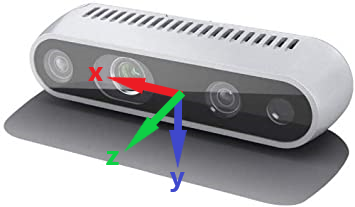



There are three foundamental parameters of the camera, that we need to know for our purpose:


*   focal length $(fx, fy)$
*   optical center $(cx, cy)$
*   depth scale

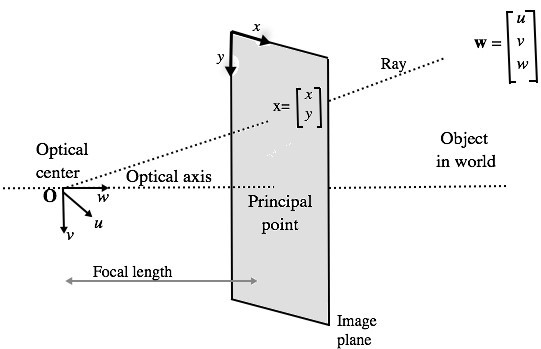




The depth scale is the semantic meaning of the values in depth images. For some cameras, the value of the pixels in depth images are the distance in the scale of 5mm, so for example if an obstacles is 2 meter away from the camera, the value of the pixels is $2000 / 5 = 400$. For this camera the value of each pixel of the depth images is exactly the distance in millimeter from the obstacle. So we defined the parameter *depth_scale* as 0.001 to multiply these values, in order to obtain the distance in meters. 

In [ ]:
#parameters of our camera
fx = 616.860901  # focal length x
fy = 617.486267  # focal length y
cx = 322.530548  # optical center x
cy = 241.111053  # optical center y

depth_scale = 0.001 # scaler factor to pass from depth in mm to meter

## **Point clouds**

Once explained the camera variables, to clearify the dataset composition and the network training, we need to explain what point clouds are.

Having the camera informations, it is possible to project a 2D point in the 3D space and viceversa. The projection of each pixel of a 2D image in the 3D space is called point cloud.
Point clouds can also be colorized, if RGB information are used.

In the image below, the camera perspective model is illustrated.

The coordinates $(u, v)$ are the 2D coordinates of the point $L$ in the image coordinate system. The coordinates $(X_c, Y_c, Z_c)$ are the 3D coordinates of the same point in the camera coordinate systems. The relations between the 2D and 3D points and the camera parameters are shown below.

$u = \frac{(f_x \times X_c)} {Z_c} + c_x$

$v = \frac{(f_y \times Y_c)}{Z_c} + c_y$

$Xc = \frac{(u - c_x) \times Z_c}{f_x}$

$Yc = \frac{(v - c_y) \times Z_c}{f_y}$

Having the depth images, $Z_c$ is the values in meter of each pixel of the depth images.

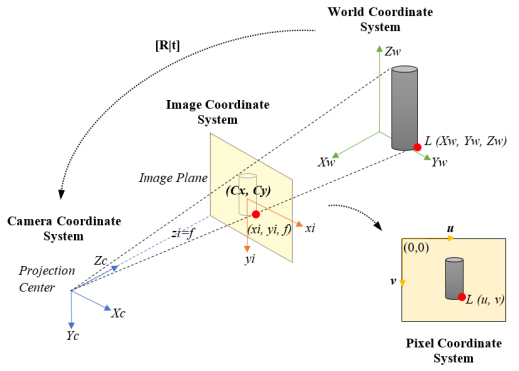

Having the RGB and the depth images, we defined a function to create the colorized point cloud for each frame. For our purpose, we used the *open3d* library, a C++ library with python bindings.
Having images of dimension 640 x 480, projecting each point in the 3D space means obtaining a point cloud of 307200 points, which is too many. So we used an open3d function to perform uniform downsampling, obtaining point clouds made up by 5120 points. We calculate the normals of each point too, for reasons that will be explained in the following.

The parameter *downsample_for_points*, set to 60 as default, means that only one point each 60 will be maintained ($307200 / 60 = 5120$ points). The last two parametrs are used for normals estimation, they are default values suggested by open3d documentation.



In [ ]:
def create_pcd(depth_image, rgb_image, downsample_for_points=60, kd_tree_radius = 0.1, max_neighbors = 30):
  points = []
  colors = []
  for v in range(depth_image.shape[0]):
    for u in range(depth_image.shape[1]):
      Z = depth_image[v][u] * depth_scale #depth value from mm to meter
      X = (u - cx) * Z / fx
      Y = (v - cy) * Z / fy
      points.append(np.array([X, Y, Z]))
      colors.append(rgb_image[v][u])
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)
 
  down_pcd = pcd.uniform_down_sample(downsample_for_points) #downsampling
  down_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=kd_tree_radius, max_nn=max_neighbors)) #normals estimation
  return down_pcd
  

The next function uses the plotly library to plot 3D point clouds.

In [ ]:
def plot_pcd(pcd, colors, marker_size=1):
  fig = go.Figure(
    data=[
      go.Scatter3d(
        x=pcd[:,0], y=pcd[:,1], z=pcd[:,2], 
        mode='markers',
        marker=dict(size=marker_size, color=colors)
      )
    ],
    layout=dict(
      scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
      )
    )
  )
  fig.show()

In the following an example of point cloud is shown. To create the point cloud, the first rgb and depth images of the first sequence are used.

In [ ]:
example_path = '/content/drive/MyDrive/rgbd_dataset/00/'
img_names = [name for name in os.listdir(example_path + "rgb/")]
img_names.sort() 

rgb_image = np.asarray(load_img(example_path + 'rgb/' + img_names[0])) / 255 #shape (480, 640, 3)
depth_image =  np.asarray(load_img(example_path + 'depth/' + img_names[0], color_mode='grayscale')) #shape (480, 640)

In [ ]:
plt.imshow(rgb_image)

Remember that depth images are 16-bit single channel images and the value of each pixel is the distance in millimeters from the objects. So higher is the distance and higher is the value (and lighter is the color).

In [ ]:
plt.imshow(depth_image, cmap='gray')

In [ ]:
pcd = create_pcd(depth_image, rgb_image)

points = np.array(pcd.points)
colors = np.array(pcd.colors)

The following two cells we plot the downsampled point cloud, with 5120 points. In the first cell, it's not easily understadable that it's the point cloud created by the two previous images, so in the second cell we plot the same point cloud with bigger markers, to make it clear. You can rotate and zoom the point clouds in the graphs if you want.

You can notice that positioning the mouse on a point will show you the coordinates $x$, $y$ and $z$ of the point, with respect to the point $(0, 0, 0)$ that is the camera position.

In [ ]:
plot_pcd(points, colors)

In [ ]:
plot_pcd(points, colors, marker_size=6)

### **Point clouds registration**

We refer to point clouds registration as the process of aligning different overlapping point clouds. We introduced here the **Iterative Closest Point algorithm (ICP)** that is a famous point clouds registration algorithm and it's used in dataset creation.

ICP is an iterative algorithm, that solves the alignment of two point clouds as a least square minimization problem.

In general, the ICP algorithm iterates over two steps:

1.   find correspondence set $K={(p,q)}$ from target point cloud $P$, and source point cloud $Q$ transformed with current transformation matrix $\mathbf{T}$.
2.   update the transformation $\mathbf{T}$ by minimizing an objective function $E(\mathbf{T})$ defined over the correspondence set $K$.

Based on the objective function to minimize, there are two main types of ICP:


*   point-to-point
*   point-to-plane

In our project we use the point to plane algorithm, because it's more accurate and it converges faster when there are several plane surfaces in the point clouds, such as in human environments, where there are walls.

The objective function of the point-to-plane ICP is the following:

$E(\mathbf{T}) = \sum_{(p, q) \in K}((p - \mathbf{T}q) \cdot n_p)^2$

where $n_p$ is the normal of $p$. 

So point-to-plane ICP uses the normals of points, for this reason in the function *create_pcd* we compute the normals of the point clouds.

For more detail you can refer to open3d documentation http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html.



This is a gif to clearify the ICP operation.

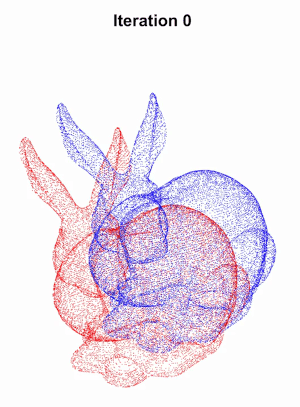

In the following we defined a function to compute the point-to-plane ICP between an open3d source point cloud and an open3d target point cloud. The registration is an open3d object that contains:
*   the fitness and the rmse of the ICP
*   the transformation needed to align the two point clouds 
*   the set of corresponding points, that are those points that match in the two point clouds

In [ ]:
def compute_registration(source, target):
  registration = o3d.pipelines.registration.registration_icp(source, 
                                                             target, 
                                                             0.05,      #maximum distance to define corresponding points
                                                             np.eye(4), #initial estimation, identity matrix
                                                             o3d.pipelines.registration.TransformationEstimationPointToPlane(), #point-to-plane
                                                             o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100)) #convergence criteria
  return registration
            

In the following cell an example is shown. The first two pair of RGB and depth images of the first sequence are used in order to register the respective point clouds.

In [ ]:
example_path = 'drive/MyDrive/rgbd_dataset/00/'
img_names = [name for name in os.listdir(example_path + "rgb/")]
img_names.sort() 

rgb_image1 = np.asarray(load_img(example_path + 'rgb/' + img_names[0])) / 255 #shape (480, 640, 3)
depth_image1 =  np.asarray(load_img(example_path + 'depth/' + img_names[0], color_mode='grayscale')) #shape (480, 640)

rgb_image2 = np.asarray(load_img(example_path + 'rgb/' + img_names[1])) / 255 #shape (480, 640, 3)
depth_image2 =  np.asarray(load_img(example_path + 'depth/' + img_names[1], color_mode='grayscale')) #shape (480, 640)

pcd1 = create_pcd(depth_image1, rgb_image1)
pcd2 = create_pcd(depth_image2, rgb_image2)

registration = compute_registration(pcd1, pcd2)

print(registration)
print("Transformation estimated: \n", np.array(registration.transformation))
print("Correspondences set: \n", np.array(registration.correspondence_set))

## **Dataset**

In the following cells we explain how we created the dataset and what is its organization.

### **Dataset creation**

The dataset is composed by 8 sequences, and for each sequence these elements are used:

*   RGB images
*   depth images
*   pre-computed point clouds
*   pre-computed corresponding points between two successive point clouds

The pre-computed point clouds and the pre-computed corresponding points are used in the 3D spatial loss function and will be discussed in that section.





To create the dataset, we computed the point clouds for each pair of RGB and depth images using the *create_pcd* function, then we computed the registration between each two successive point clouds with the function *compute_registration*, and finally we saved the set of correspondences for each successive point clouds of any sequence as a .npy file. Here we use a trick in order to use these correspondences in the training. Since correspondences between each pair of point clouds can have different dimensions, and it is a problem for Keras tensors, we fill the arrays with -1 values, in order to have all the arrays with 5120 correspondences. Then, in the training, we filter them, keeping only correspondences that are different from -1.

### **Dataset organization**

The dataset is composed by 8 indoor RGBD sequences. 
The first four sequences are used for the training set. They are captured in an home environment.
The two validation sequences are university environments, a room and a corridor.
The two test sequences are respectively an office corridor and an environment with several rooms.

In the following these sequences are explained in a more detailed way:


*   sequence **00** is composed by 2683 RGBD images. It's the first floor of the house, captured with a good light condition.
*   sequence **01** is composed by 1003 RGBD images. It starts on the ground floor of the house and go up the stairs to the first floor.
*   sequence **02** is composed by 652 RGBD images. It starts on the first floor of the house and go down the stair to the ground floor.
*   sequence **03** is composed by 1505 RGBD images. It's the first floor of the house, the sequence is very similar to the sequence 00, but in this case it was captured in the dark, with a very low light condition.
*   sequence **04** is composed by 1669 RGBD images. It's a room of the Cesena Campus.
*   sequence **05** is composed by 2632 RGBD images. It's a long corridor of the Cesena Campus.
*   sequence **06** is composed by 1400 RGBD images. It's a corridor of a public office.
*   sequence **07** is composed by 1555 RGBD images. It's an indoor environment composed by several rooms connected by a short corridor.




In [ ]:
train_sequences = ["00", "01", "02", "03"]
valid_sequences = ["04", "05"]
test_sequences = ["06", "07"]

### **Loading the dataset**

We used a *batch_size* = 32 and a *time_steps* = 5 for the LSTM. The variable *data_steps* is used because since we need to concatenate two successive images, the number of images needed for the *time_steps* is *time_steps* + 1

In [ ]:
time_steps = 5
data_steps = time_steps + 1
batch_size = 32

In [ ]:
root_path = "drive/MyDrive/rgbd_dataset/"

The dataset is composed by batch of exactly *batch_size* sequences of *time_steps* elements. In the training, sequences are shuffled.

In [ ]:
def build_dataset(sequences, root_path=root_path, batch_size=batch_size, data_steps=data_steps, training=True):
  
  dataset = []

  for seq_name in sequences:
    seq_path = root_path + seq_name + "/"
    rgb_path = seq_path + "rgb/"
    depth_path = seq_path + "depth/"
    pcd_path = seq_path + "pcd/"
    matches = np.load(seq_path + "matches.npy")
    rgb_images = [rgb_path + name for name in os.listdir(rgb_path)]
    depth_images = [depth_path + name for name in os.listdir(depth_path)]
    pcd = [pcd_path + name for name in os.listdir(pcd_path)]
    rgb_images.sort()
    depth_images.sort()
    pcd.sort()
    
    length = matches.shape[0] // data_steps * data_steps
    
    rgb_paths_sequenced = [rgb_images[i:i+data_steps] for i in range(0, length, data_steps)]  
    depth_paths_sequenced = [depth_images[i:i+data_steps] for i in range(0, length, data_steps)]  
    pcd_paths_sequenced = [pcd[i:i+data_steps] for i in range(0, length, data_steps)]  
    matches_sequenced = [matches[i:i+data_steps] for i in range(0, length, data_steps)] 
    
    for i in range(len(rgb_paths_sequenced)):
      dataset.append((rgb_paths_sequenced[i], depth_paths_sequenced[i], pcd_paths_sequenced[i], matches_sequenced[i]))
    
    
  if training:
    np.random.shuffle(dataset)
  seq_size = (len(dataset) // batch_size) * batch_size
  dataset = [x for index, x in enumerate(dataset) if index < seq_size]      
  return dataset

In the next code cell a function to create a single test sequence is implemented. Since we need to divide a sequence in batch, to evaluate the total sequence it mustn't be interrupted by this division, so in the creation of the batch we used *data_steps* - 1 instead of *data_steps* directly.

Using *data_steps* in the creation leads to the following result. We lost the transformation between images at time $t_n$ and $t_{n+1}$. It's ok for the training and the validation set (in particular, it's necessary for the training set where sequences are shuffled), but in the test step we need to compute the entire sequence path, so we need the transformation between each pair of successive images.

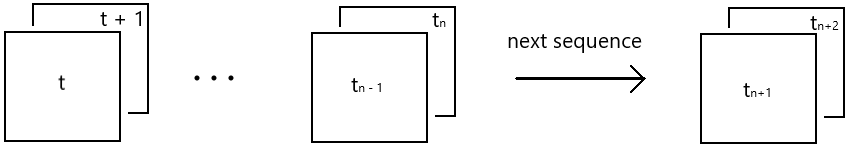

Using *data_steps* - 1 we obtain the desired test set.

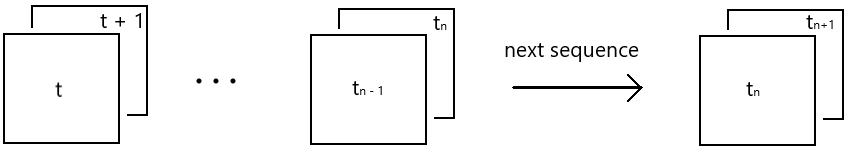

In [ ]:
def build_test_sequence(sequence_name, root_path=root_path, batch_size=batch_size, data_steps=data_steps):

    sequence_path = root_path + sequence_name
    dataset = []
    
    rgb_path = sequence_path + "/rgb/"
    depth_path = sequence_path + "/depth/"
    pcd_path = sequence_path + "/pcd/"
    matches = np.load(sequence_path + "/matches.npy")
    
    rgb_images = [rgb_path + name for name in os.listdir(rgb_path)]
    depth_images = [depth_path + name for name in os.listdir(depth_path)]
    pcd = [pcd_path + name for name in os.listdir(pcd_path)]
    
    rgb_images.sort()
    depth_images.sort()
    pcd.sort()
    
    length = matches.shape[0] // data_steps * data_steps
    
    rgb_paths_sequenced = [rgb_images[i:i+data_steps] for i in range(0, length, data_steps - 1)]  
    depth_paths_sequenced = [depth_images[i:i+data_steps] for i in range(0, length, data_steps - 1)]  
    pcd_paths_sequenced = [pcd[i:i+data_steps] for i in range(0, length, data_steps - 1)]  
    matches_sequenced = [matches[i:i+data_steps] for i in range(0, length, data_steps - 1)]
    
    for i in range(len(rgb_paths_sequenced)):
        dataset.append((rgb_paths_sequenced[i], depth_paths_sequenced[i], pcd_paths_sequenced[i], matches_sequenced[i]))
    
    seq_size = (len(dataset) // batch_size) * batch_size
    dataset = [x for index, x in enumerate(dataset) if index < seq_size]      
    return dataset

In [ ]:
train_dataset = build_dataset(train_sequences)
valid_dataset = build_dataset(valid_sequences)
test_dataset = [build_test_sequence(sequence) for sequence in test_sequences]

In the following cells the sequence generators are created.
The data are divided in batches of size=*batch_size* and sequences of size=*time_steps*. 
The returned value is a tuple of five batches, that are batches of:


*   6 channel tensor, composed by two successive concatenated RGB images
*   6 channel tensor, composed by two successive depth images, concatenated three times
*   the point cloud at time $t$, that is the source point cloud
*   the point cloud at time $t+1$, that is the target point cloud
*   the set of corresponding points in the two point clouds

Images are resized at dimension 320 x 240.


In [ ]:
class SequenceGenerator(Sequence):
  def __init__(self,
               dataset,
               data_steps=data_steps,
               batch_size=batch_size,
               shuffle=True
               ):
    self.dataset = dataset
    self.data_steps = data_steps
    self.batch_size = batch_size
    self.len = len(self.dataset) // self.batch_size
    self.shuffle = shuffle

  # number of batches
  def __len__(self):
    return self.len

  # return the index-th batches
  def __getitem__(self, index):
    rgb_batch = []
    depth_batch = []
    current_pcd_batch = []
    next_pcd_batch = []
    corr_batch = []
    for i in range(index * self.batch_size, (index + 1) * self.batch_size): # for n elem in batch_size 
      rgb_paths, depth_paths, pcd_paths, correspondences = self.dataset[i]
      rgb_sequence = []
      depth_sequence = []
      current_pcd_sequence = []
      next_pcd_sequence = [] 
      corr_sequence = []
      for j in range(self.data_steps - 1):
        rgb_image1 = tf.image.resize(np.asarray(load_img(rgb_paths[j])) / 255, (240, 320), method="nearest")
        rgb_image2 = tf.image.resize(np.asarray(load_img(rgb_paths[j + 1])) / 255, (240, 320), method="nearest")
        rgb = np.concatenate((rgb_image1, rgb_image2), axis = 2)

        depth_image1_single_channel = tf.image.resize(np.expand_dims(np.asarray(load_img(depth_paths[j], color_mode='grayscale')), axis = 2), (240, 320), method="nearest")
        depth_image2_single_channel = tf.image.resize(np.expand_dims(np.asarray(load_img(depth_paths[j + 1], color_mode='grayscale')), axis = 2), (240, 320), method="nearest")
        depth_image1 = np.concatenate((depth_image1_single_channel, depth_image1_single_channel, depth_image1_single_channel), axis = 2)
        depth_image2 = np.concatenate((depth_image2_single_channel, depth_image2_single_channel, depth_image2_single_channel), axis = 2)
        depth = np.concatenate((depth_image1, depth_image2), axis = 2)
                
        current_pcd = o3d.io.read_point_cloud(pcd_paths[j])
        next_pcd = o3d.io.read_point_cloud(pcd_paths[j + 1])
                
        current_pcd_points = np.array(current_pcd.points)
        next_pcd_points = np.array(next_pcd.points)
                
        corr = correspondences[j]
                                
        rgb_sequence.append(rgb)
        depth_sequence.append(depth)
        current_pcd_sequence.append(current_pcd_points)
        next_pcd_sequence.append(next_pcd_points) 
        corr_sequence.append(corr)
                
      rgb_batch.append(np.array(rgb_sequence))
      depth_batch.append(np.array(depth_sequence))
      current_pcd_batch.append(np.array(current_pcd_sequence))
      next_pcd_batch.append(np.array(next_pcd_sequence))
      corr_batch.append(np.array(corr_sequence))
    return np.array(rgb_batch), np.array(depth_batch), np.array(current_pcd_batch, dtype="float32"), np.array(next_pcd_batch, dtype="float32"), np.array(corr_batch, dtype="int32")

  def on_epoch_end(self):
    np.random.shuffle(self.dataset)

In [ ]:
train_generator = SequenceGenerator(train_dataset)
valid_generator = SequenceGenerator(valid_dataset)
test_generator = [SequenceGenerator(sequence) for sequence in test_dataset]

In the following the first batch of the training set is shown.

In [ ]:
rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr_batch = train_generator[0]

The function *plot_successive* plot a pair of image.

In [ ]:
def plot_successive(image1, image2, cmap=None):
  n_rows = 1
  n_cols = 2

  k = 0

  fig = plt.figure(figsize=(15,10))
  for i in range(1, 2 * n_rows + 1):
    fig.add_subplot(n_rows, n_cols, i)
    if i % 2 == 1:
      image = image1 
    else:
      image = image2 
      k += 1
    plt.imshow(image, cmap=cmap)  

First concatenated tensor in the first sequence.

In [ ]:
plot_successive(rgb_batch[0][0][:, :, :3], rgb_batch[0][0][:, :, 3:])

In [ ]:
plot_successive(depth_batch[0][0][:, :, 0], depth_batch[0][0][:, :, 3], cmap="gray")

Last concatenated tensor in the first sequence.

In [ ]:
plot_successive(rgb_batch[0][time_steps - 1][:, :, :3], rgb_batch[0][time_steps - 1][:, :, 3:])

In [ ]:
plot_successive(depth_batch[0][time_steps - 1][:, :, 0], depth_batch[0][time_steps - 1][:, :, 3], cmap="gray")

The corresponences are in the following form. These are the corresponding points in the first two point clouds in the first batch. Each tuple contains the index of a point in the point cloud at time $t$ and the index of the corresponding point in the point cloud at time $t +1$. 

As said before, since the correspondences set can be of different shape for each couple of point clouds, we filled them with value -1, to obtain always tensor of 5120 elements.

In [ ]:
print(corr_batch[0][0])

## **Loss function**

In the paper we referred, the loss function is a composed loss function, made up by two loss functions:


*   **3D spatial loss** that computes the geometric error, which is the sum of the euclidean distances between corresponding points in the true point cloud and the estimated point cloud (explained below). So it depends only on the depth images;
*   **2D spatial loss** that computes the error as the difference of the pixels values of the image obtained by projecting each pixel in the 3D space, by applying the transformation predicted to the 3D points and then by backprojecting the points in the 2D space. So it depends only on the RGB images.

We used only the 3D spatial loss for the following reasons:


*   2D spatial loss is very useful in outdoor environments, where maybe obstacles are too distance to create an accurate depth image, and this loss can improve the accuracy of the composed loss;

*   since our sequence are only indoor environment, with good depth images, we want to try to use only the 3D spatial loss to understand if and how much the 2D spatial loss is useful in this scenario. As said before, we think 2D spatial loss can be more useful in outdoor environments;

*   the 3D spatial loss doesn't rely on the pixels values, so we introduced in our experiments also a very low light sequence, because, in theory, this loss function should allow to train the network with sequences captured also in the dark. This could have very interesting applications, for example for visual odometry in places where there is no light (such as caves).



In [ ]:
def euler_to_matrix(euler): #euler is a vector in the form [yaw, pitch, roll]
  yaw = euler[0]
  pitch = euler[1]
  roll = euler[2]
  R_z = tf.stack([tf.stack([tf.math.cos(yaw), -tf.math.sin(yaw), 0.0]), tf.stack([tf.math.sin(yaw), tf.math.cos(yaw), 0.0]), tf.stack([0.0, 0.0, 1.0])])
  R_y = tf.stack([tf.stack([tf.math.cos(pitch), 0.0, tf.math.sin(pitch)]), tf.stack([0.0, 1.0, 0.0]), tf.stack([-tf.math.sin(pitch), 0.0, tf.math.cos(pitch)])])
  R_x = tf.stack([tf.stack([1.0, 0.0, 0.0]), tf.stack([0.0, tf.math.cos(roll), -tf.math.sin(roll)]), tf.stack([0.0, tf.math.sin(roll), tf.math.cos(roll)])])
    
  R = K.dot(K.dot(R_z, R_y), R_x)
    
  return R

### **3D spatial loss**

The 3D spatial loss computes the *geometric error*, that is the mean of the euclidean distance between the estimated point cloud, obtained by applying the predicted transformation to the point cloud at time $t$, and the point cloud ad time $t + 1$. 

Computing the euclidean distance between to point clouds, means knowing the corresponding points of the two, and calculating the euclidean distance between each pair of them.

But why we pre-compute the corresponding set of points between two successive point clouds in the dataset (the point cloud at time $t$ and the point cloud at time $t+1$) if we calculate the error on the set of correspondences of the estimated point cloud (that we cannot know a priori, because it depends on the network prediction) and the point cloud at time $t+1$?

**Because the set of corresponding points of the point cloud at time $t$ and the point cloud at time $t + 1$ is the same as the estimated point cloud and the true point cloud at time $t + 1$.**

Below, a description with images is done in order to clearify this point.

Imagining to have two point clouds at time $t$ and at time $t+1$, it's probably that not all the points present in the first one, will be in the second one, because we're moving, and in the second one there will be new points. Performing ICP on these two point clouds, we find the corresponding points, that are the green points in the figure below. The orange points are those points that not match in the two point clouds.

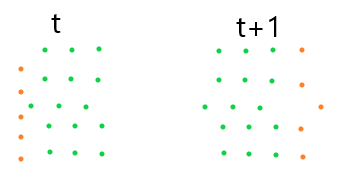

The estimated point cloud is obtained by applying the transformation $\mathbf{T}$ predicted by the network to the point cloud at time $t$. So, it's just applying a rotation and a translation, but the points are the same as the point cloud at time $t$.

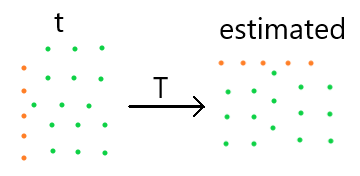

In this way, the corresponding points between the point cloud at time $t$ and at time $t+1$ are exactly the same as between the estimated point cloud and the point cloud at time $t+1$, **because the estimated point cloud and the point cloud at time $t$ are made up by exactly the same points**.

Using this trick, we can pre-compute all the corresponding points for each pair of successive point clouds and then in the loss function we calculate the euclidean distance between each pair of corresponding points in the estimated point cloud and the point cloud at time $t+1$, that is the error.

In the image below only few matches are highlighted.

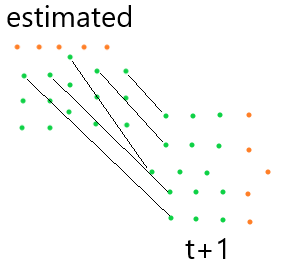

In [ ]:
#higher order function to apply the rotation and the translation predicted to all the points of a point cloud
def apply_transformation(rotation, translation):
  def apply(point):
    return tf.math.add(K.dot(rotation, point), translation)
  return apply

In [ ]:
def spatial_loss_3D(rotations_batch, translations_batch, current_pcd_batch, next_pcd_batch, correspondences_batch):
  batch_loss = 0.0
  
  for i in range(tf.shape(rotations_batch)[0]): #for each sequence in batch
    sequence_loss = 0.0
    for j in range(tf.shape(rotations_batch)[1]): #for each element in sequence            
      
      translation = translations_batch[i][j]
      rotation = rotations_batch[i][j]
      current_points = current_pcd_batch[i][j]
      next_points = next_pcd_batch[i][j]       
      correspondences = correspondences_batch[i][j]
            
      translation= tf.expand_dims(translation, 1) #from (3,) to (3, 1)
            
      rotation_matrix = euler_to_matrix(rotation) #euler to matrix conversion

      current_points_tensor = tf.expand_dims(current_points, 2) #from (5120, 3) to (5120, 3, 1)
      next_points_tensor = tf.expand_dims(next_points, 2) #from (5120, 3) to (5120, 3, 1)

      #apply the rotation and the translation to all the points of current point cloud    
      next_points_estimated = tf.vectorized_map(fn=apply_transformation(rotation_matrix, translation), elems=current_points_tensor)
                        
      #tensor of type [[True, True], ... [False, False]], False corresponds to -1
      correspondences_boolean_mask = tf.not_equal(correspondences[:], tf.constant(-1))
           
      #tensor of type [[p1_1, p2_1] ...[p1_n, p2_n]] where p1_n and p2_n are the indices of points that corresponds in the two point clouds
      #it uses the correspondences_boolean_mask as a boolean mask to filter out all the -1 correspondences
      filtered_indices = tf.boolean_mask(correspondences, correspondences_boolean_mask[:, 0])
      
      #tensors with the corresponding points. 
      next_corr_estimated = tf.gather(next_points_estimated, filtered_indices[:, 0])
      next_corr_true = tf.gather(next_points_tensor, filtered_indices[:, 1])
            
      error = K.mean(K.sqrt(K.sum(K.square(next_corr_estimated - next_corr_true), axis=1)))
      sequence_loss += error
               
    batch_loss += sequence_loss
  return batch_loss

## **Model**

The model is the same as those proposed in the paper.

In Keras we use TimeDistributed layer to distribute trainable layers over time steps.

In [ ]:
def build_model():
  rgb = Sequential([
                    Input(shape=(240, 320, 6), name="Input_rgb"),
                    ZeroPadding2D(padding=3),
                    Conv2D(16, 7, strides=3, activation="relu", name="Conv1_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=2),
                    Conv2D(32, 5, strides=2, activation="relu", name="Conv2_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=1),
                    Conv2D(64, 3, strides=2, activation="relu", name="Conv3_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=1),
                    Conv2D(128, 3, strides=2, activation="relu", name="Conv4_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv5_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv6_rgb", kernel_regularizer=tf.keras.regularizers.l2()),
                    ZeroPadding2D(padding=1),
                    Conv2D(512, 3, strides=2, activation="relu", name="Conv7_rgb", kernel_regularizer=tf.keras.regularizers.l2())
                    ])
  depth = Sequential([
                      Input(shape=(240, 320, 6), name="Input_depth"),
                      ZeroPadding2D(padding=3),
                      Conv2D(16, 7, strides=3, activation="relu", name="Conv1_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=2),
                      Conv2D(32, 5, strides=2, activation="relu", name="Conv2_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=1),
                      Conv2D(64, 3, strides=2, activation="relu", name="Conv3_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=1),
                      Conv2D(128, 3, strides=2, activation="relu", name="Conv4_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=1),
                      Conv2D(256, 3, strides=2, activation="relu", name="Conv5_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=1),
                      Conv2D(256, 3, strides=2, activation="relu", name="Conv6_depth", kernel_regularizer=tf.keras.regularizers.l2()),
                      ZeroPadding2D(padding=1),
                      Conv2D(512, 3, strides=2, activation="relu", name="Conv7_depth", kernel_regularizer=tf.keras.regularizers.l2())
                      ])
  
  rgb_input = Input(shape=(None, 240, 320, 6))
  depth_input = Input(shape=(None, 240, 320, 6))
  rgb_cnn = TimeDistributed(rgb)(rgb_input)
  depth_cnn = TimeDistributed(depth)(depth_input)
  
  rgb_flat = TimeDistributed(Flatten())(rgb_cnn)
  depth_flat= TimeDistributed(Flatten())(depth_cnn)
  rgbd = concatenate([rgb_flat, depth_flat])
  dense = TimeDistributed(Dense(rgbd.shape[2], name="rgbd_dense"))(rgbd)

  lstm = LSTM(256, name="lstm_rgbd", return_sequences=True)(dense)

  rotation = TimeDistributed(Dense(256, name="rotation_dense_1", activation="elu"))(lstm)
  rotation = TimeDistributed(Dense(256, name="rotation_dense_2", activation="elu"))(rotation)
  rotation_output = TimeDistributed(Dense(3, name="rotation_output"))(rotation)

  translation = TimeDistributed(Dense(256, name="translation_dense_1", activation="elu"))(lstm)
  translation = TimeDistributed(Dense(256, name="translation_dense_2", activation="elu"))(translation)
  translation_output = TimeDistributed(Dense(3, name="translation_output"))(translation)

  model = Model(inputs=[rgb_input, depth_input], outputs=[rotation_output, translation_output])

  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

## **Training**

In [ ]:
@tf.function
def train_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr):
    with tf.GradientTape() as tape:
        results = model([rgb_batch, depth_batch], training=True)
        loss_value = spatial_loss_3D(results[0], results[1], current_pcd_batch, next_pcd_batch, corr)
            
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

@tf.function
def val_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr):
    results = model([rgb_batch, depth_batch], training=False)
    loss_value = spatial_loss_3D(results[0], results[1], current_pcd_batch, next_pcd_batch, corr)
    return loss_value

We trained the model for 200 epochs. We used a very low learning rate and Adam as optimizer.

We tried to use learning rate = 0.002 as explained in the paper, but we saw that the training was too unstable, the loss function decrease and increase a lot, so we used a lower learning rate to stabilize the training.

In [ ]:
n_epoch = 200

learning_rate = 0.00003
reducing_factor = 0.3334
optimizer = Adam(learning_rate=learning_rate)

min_val_loss = 9999999999

In [ ]:
train_loss_history = []
val_loss_history = []

In [ ]:
for epoch in range(n_epoch):
  print("Epoch ", epoch)
  start_time = time.time()
  epoch_train_loss = 0.0
  epoch_valid_loss = 0.0
    
  #after 100 epochs the learning rate decrease of reducing_factor
  if epoch % 100 == 0 and epoch != 0:
    learning_rate = learning_rate * reducing_factor
    optimizer.lr.assign(learning_rate)
    print("Current learning rate: ", learning_rate)
  
  for rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr in train_generator:
    loss = train_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr)
    epoch_train_loss += loss
  epoch_train_loss /= train_generator.len

  train_generator.on_epoch_end() #shuffle the sequences
    
  for rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr in valid_generator:
    loss_value = val_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr)
    epoch_valid_loss += loss_value
    
  epoch_valid_loss /= valid_generator.len

  if epoch_valid_loss < min_val_loss:
    min_val_loss = epoch_valid_loss
    model.save("RGBDOdonet.h5")
  
  train_loss_history.append(epoch_train_loss)
  val_loss_history.append(epoch_valid_loss)
  
  print("Train loss: %.4f, Valid loss: %.4f" % (epoch_train_loss, epoch_valid_loss))
  print("Epoch time: %.2fs" % (time.time() - start_time))    

In [ ]:
np.save("train_loss.npy", train_loss_history)
np.save("val_loss.npy", val_loss_history)

### **History**

In [ ]:
rgbd_path = "drive/MyDrive/RGBDOdonet/"

In [ ]:
train_loss_history = np.load(rgbd_path + "train_loss.npy")
val_loss_history = np.load(rgbd_path + "val_loss.npy")

In [ ]:
plt.plot(train_loss_history)

In [ ]:
plt.plot(val_loss_history, color="orange")

History shows a drastic drop of the loss value since the first epoch, than the training loss is stable for all the training, while the validation loss decreases until the end of the training, so there isn't an overfitting condition.

## **Performance evaluation**

We load the model saved at the end of the training, because it's the best one.

In [ ]:
model = tf.keras.models.load_model(rgbd_path + "RGBDOdonet.h5")

In [ ]:
@tf.function
def test_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr):
    results = model([rgb_batch, depth_batch], training=False)
    loss_value = spatial_loss_3D(results[0], results[1], current_pcd_batch, next_pcd_batch, corr)
    return results, loss_value

### **Save data for the evaluation**

We saved the loss value, the translations and the rotations predicted for each sequence, to load them in the following.

In [ ]:
losses = []
translations_sequence = []
rotations_sequence = []

For each test sequence, the function *test_step* compute the predictions of 5 *time_steps*, so we append the predictions of all *time_steps* to obtain the predictions on the entire sequence.

In [ ]:
for generator in test_generator:
  final_loss = 0.0
  translations = []
  rotations = []
  previous_rotation = tf.eye(3) #initial rotation is the identity
  previous_translation = tf.reshape(tf.zeros(3), (3,1)) #initial translation is the origin
  translations.append(previous_translation)
  rotations.append(previous_rotation)
  for rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr in generator:
    results, loss = test_step(rgb_batch, depth_batch, current_pcd_batch, next_pcd_batch, corr)
    for seq_num in range(tf.shape(results[0])[0]):
      for elem_num in range(tf.shape(results[0])[1]):
        rotation = euler_to_matrix(results[0][seq_num, elem_num]) #euler to matrix
        translation = tf.reshape(results[1][seq_num, elem_num], (3,1)) #from shape (3,) to (3, 1)

        #pose updating formula
        next_translation = previous_translation + K.dot(previous_rotation, translation)
        next_rotation = K.dot(rotation, previous_rotation)
                
        translations.append(next_translation)
        rotations.append(next_rotation)

        previous_rotation = next_rotation
        previous_translation = next_translation
        
      final_loss += loss
  translations_sequence.append(translations)
  rotations_sequence.append(rotations)
  final_loss /= generator.len
  losses.append(final_loss)

In [ ]:
np.save("RGBDOdonet_loss.npy", losses)

In [ ]:
for i, seq in enumerate(test_sequences):
  np.save(seq + "_rotations.npy", rotations_sequence[i])
  np.save(seq + "_translations.npy", translations_sequence[i])

### **Load data for the evaluation**

In [ ]:
losses = np.load(rgbd_path + "RGBDOdonet_loss.npy")

The loss value for the two test sequence is very high. It's the mean distance in meter of each point of the estimated point cloud from its corresponding point in the target point cloud, for all the point clouds in the sequence.

In [ ]:
for i, seq in enumerate(test_sequences):
  print("Loss value for sequence %s: %f" % (seq, losses[i]))

#### **Plotted results**

The high error is easily visible by plotting the poses obtained.

**Sequence 06**

In [ ]:
translations_06 = np.load(rgbd_path + "06_translations.npy")

In [ ]:
plt.scatter(translations_06[:, 0], translations_06[:, 2], s = 0.1)

The predicted path is totally wrong. Not only for the shape of the path, but also for the scale. The corridor captured in the sequence is much more longer than 6 meter.

We tried to hand draw the ground truth path of the sequence (obviously, ignoring the correct scale and distances) and it should be like this

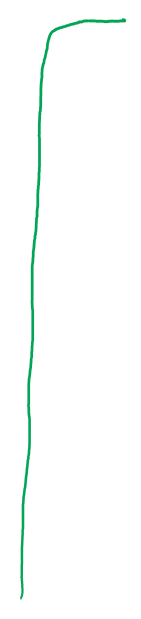

It's a long straight corridor and the sequence ends with a right turn.

**Sequence 07**

In [ ]:
translations_07 = np.load(rgbd_path + "07_translations.npy")

In [ ]:
plt.scatter(translations_07[:, 0], translations_07[:, 2], s = 0.1)

Here the path is totally wrong too. The shape is a bit more similar to the true one, but it's still really wrong. 

In this sequence we started on the entrance of a room, then we go into the room and explore a room on the left, we turn right and go back to the entrance of the first room. Here we have traveled a short corridor to a third room and we explored the room. Then we turn left and we traveled again the corridor, to return to the starting point. 

The hand draw ground truth is the following

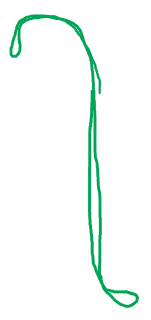

## **Final considerations**

As the results show, this network hasn't learned anything. The path predicted are obviously not correct at all. The reasons behind these results could be many.

### **Inaccurate point cloud registration**

We think a problem could be that the point clouds are downsampled. Obviously it's necessary for our purpose, because we haven't the computational power and instruments to handle point clouds composed by 307200 points. This downsampling doesn't ensure that corresponding points in the two images are maintained, because it's done before registration. This can lead to incorrect correspondences found by the ICP, that can make the spatial loss calculation, and therefore the training process, less accurate.

### **Frame rate**

The frame rate of the camera could be another factor of influence of this results. The frame rate was 30fps, an high frame rate. A frame at time $t$ is very similar to the frame at time $t+1$, so there are no appreciable differences between the two, and the transformation to learn is composed by values very close to zero.

### **Absence of 2D spatial loss**

As said at the beginning of this section, we wanted to test if the 2D spatial loss is necessary also in indoor environment. Probably it is, to improve the accuracy of the network, especially if the point clouds registration is not perfect as in our case.

### **Possible augmentation of the training set**

A possible solution to increase the accuracy of the prediction, could be create a bigger training set. In our solution we concatenate tensors five by five, without repetition. For example, we take 10 tensors, from time $t_0$ to time $t_9$, divided in two sequences composed by five tensors. Therefore the first sequence contains tensors from time $t_0$ to time $t_4$ and the second one from time $t_5$ to time $t_9$. An idea could be to create overlapped sequences, for example the first sequence contains tensors from time $t_0$ to time $t_4$, the second one from time $t_1$ to time $t_5$, the third one from time $t_2$ to $t_6$ and so on.

### **Better training step**

Another possible solution could be a better choice of training parameters. As said before, we used a very low learning rate, that decays only once. This is the best configuration we found, but probably a more formal choice could lead to better results. Furthermore, the training takes very long time, so we trained the model on 200 epochs, but probably a longer training on more epoch could increase the accuracy of the model.

### **Possible improvement in the test step**


Another possibility is doing an improvement in the test step, that we left us as a future work.
Now in the test step the network predict five transformation for each sequence in batch, because the sequences are composed by five tensors (*time_steps* = 5). All this transformation are predicted by only the previous images in the same sequence. So for the first tensor, the prediction is done considering only two successive images (those concatenated in the tensor). For the second tensor, LSTM uses also previous information, so it uses three images (the first of the first tensor, the second of the second tensor, while the second of the first tensor and the first of the second tensor are the same), and so on.

An important refinement could be make the network to predict always one transformation for each sequence, the last one. In this way LSTM can always uses the information of five previous frames. For this purpose we need to concatenate and repeat more time the same image (especially at the beginning of the sequences), but we think it could be the best improvement in order to achieve better results.



# **Optical Flow**

## **Introduction**



Optical flow is the pattern of apparent motion of objects, surfaces, and edges in a visual scene caused by the **relative motion** between an observer and a scene. Optical flow can also be defined as the distribution of apparent velocities of movement of brightness pattern in an image. 

The concept of optical flow was introduced by the American psychologist James J. Gibson in the 1940s to describe the visual stimulus provided to animals moving through the world. 

The term optical flow is also used by roboticists, encompassing related techniques from image processing and control of navigation including motion detection and object segmentation.




## **TransformationNet with optical flow images**

In this experiment we tried to re-use and to adapt the TransformationNet explained before to the optical flow images. 

Each optical flow image is calculated starting from the frame at time $t$ and from the next frame at time $t + 1$.

For this operation we used the pre-trained FlowNet2, that are implemented in *PyTorch*. This network allowed us to calculate the optical flows for all the images of the sequences, which make up our dataset.

The FlowNet2 Colab, that we use for this operation are available [here](https://colab.research.google.com/drive/16vTSWbJJVECR_mHA5ozVwJQcUr8WfUH0?authuser=2#scrollTo=tWy52WXkEX7M).

We preprocessed the Kitti dataset with the FlowNet to obtain the optical flow images.

In the following we reported the useful code cells of the TransformationNet. For the explanation, please refer to the TransformationNet section.

### **Kitti sequences**

In [ ]:
root_path = "/content/drive/MyDrive/kitti_dataset/sequences/"

train_sequences = ["00", "02", "05", "08"]

val_sequences = ["01", "06", "07"]

test_sequences = ["03", "04", "09", "10"]

kitti_sequences = ["00",
                   "01",
                   "02",
                   "03",
                   "04",
                   "05",
                   "06",
                   "07",
                   "08",
                   "09",
                   "10"]

In the following we compare the first five optical flow images of the 00 sequence with the respective RGB images.

In [ ]:
n_rows = 5
n_cols = 2

k = 0

fig = plt.figure(figsize=(20,15))
for i in range(1, 2 * n_rows + 1):
  fig.add_subplot(n_rows, n_cols, i)
  if i % 2 == 1:
    path = root_path + "00/flow/00000" + str(k) + ".flo.png"
    image = img_to_array(load_img(path)) / 255
  else:
    path = root_path + "00/rgb/00000" + str(k) + ".png"
    image = img_to_array(load_img(path)) / 255
    k += 1
  plt.imshow(image)

As you can see, the dimension of the optical flow images is 384 x 128, that is smaller than the RGB images.

### **ATE metric**

In [ ]:
def ATE(transformation_predicted, pose_true):
  ATE = 0.0
  translations = []
  rotations = []
 
  previous_pose = tf.reshape(pose_true[1][0], (3, 4)) #initial pose of the batch
  previous_rotation = previous_pose[:, :3] #initial rotation of the batch
  previous_translation = tf.expand_dims(previous_pose[:, -1], axis=1) #initial translation of the batch

  translations.append(previous_translation)
  rotations.append(previous_rotation)

  sequence_length = tf.shape(transformation_predicted[0])[0] #length of the image sequence
  for i in range(sequence_length):
    rotation_predicted = euler_to_matrix(transformation_predicted[0][i]) #predicted relative rotation
    translation_predicted = tf.reshape(transformation_predicted[1][i], (3, 1)) #predicted relative translation
 
    next_pose = tf.reshape(pose_true[2][i], (3, 4)) #next pose true
    next_rotation = next_pose[:, :3] #next rotation true
    next_translation = tf.expand_dims(next_pose[:, -1], axis=1) #next translation true
             
    next_translation_predicted = previous_translation + K.dot(previous_rotation, translation_predicted) #t_new = t_pose + R_pose * t_relative
    next_rotation_predicted = K.dot(rotation_predicted, previous_rotation) # R_new = R_relative * R_pose

    translations.append(next_translation_predicted)
    rotations.append(next_rotation_predicted)

    ATE = ATE + K.sqrt(K.sum(K.square(next_translation - next_translation_predicted))) #euclidean distance

    #the previous pose is set to the new pose predicted
    previous_rotation = next_rotation_predicted
    previous_translation = next_translation_predicted
    
  ATE = K.sqrt(ATE / tf.cast(sequence_length, tf.float32)) #root mean squared error
  return ATE, translations, rotations

### **Datasets creation**

In [ ]:
batch_size = 256

In [ ]:
def build_dataset(sequences, batch_size=batch_size, training=True):
  dataset = []

  for seq_number in sequences:
    seq_path = root_path + seq_number + "/"
    img_path = seq_path + "flow/"
    sequence_paths = [img_path + name for name in os.listdir(img_path)]
    sequence_paths.sort()
    rt_ground_truth = np.load(seq_path + seq_number + "_rt.npy")
    pose_ground_truth = np.load(seq_path + seq_number + "_path.npy")
    for index in range(len(sequence_paths) - 1):
        dataset.append((sequence_paths[index], sequence_paths[index + 1], rt_ground_truth[index], pose_ground_truth[index], pose_ground_truth[index + 1]))
  if training:
    np.random.shuffle(dataset)
  seq_size = (len(dataset) // batch_size) * batch_size
  dataset = [x for index, x in enumerate(dataset) if index < seq_size]      
  return dataset

In [ ]:
def build_test_sequence(sequence):
  dataset = []

  seq_path = root_path + sequence + "/"
  img_path = seq_path + "flow/"
  sequence_paths = [img_path + name for name in os.listdir(img_path)]
  sequence_paths.sort()
  pose_ground_truth = np.load(seq_path + sequence + "_path.npy")
  for index in range(len(sequence_paths) - 1):
    dataset.append((sequence_paths[index], sequence_paths[index + 1], pose_ground_truth[index], pose_ground_truth[index + 1]))
  return dataset

In [ ]:
train_dataset = build_dataset(train_sequences)
val_dataset = build_dataset(val_sequences, training=False)
test_dataset = [build_test_sequence(sequence) for sequence in test_sequences]

In [ ]:
class SequenceGenerator(Sequence):
  def __init__(self,
               dataset, #a list of tuple of the form (current_image, next_image, relative_transformation, previous_pose, next_pose)
               batch_size=batch_size,
               shuffle=True
               ):
    self.dataset = dataset
    self.batch_size=batch_size
    self.len = len(self.dataset) // self.batch_size #number of batches
    self.shuffle = shuffle

  def __len__(self):
    return self.len

  #return the index-th batch
  def __getitem__(self, index):
    image_batch = [] #batch of image at time t and at time t+1 concatenated
        
    relative_transformations_batch = []
    previous_poses_batch = []
    next_poses_batch = []
    for i in range(index * self.batch_size, (index + 1) * self.batch_size): # for n elem in batch_size
      image1 = img_to_array(load_img(self.dataset[i][0])) / 255 #current_image
      image2 = img_to_array(load_img(self.dataset[i][1])) / 255 #next_image
      image = np.concatenate((image1, image2), axis = 2) #image with 6 channel
      image_batch.append(image)
           
      relative_transformations_batch.append(self.dataset[i][2])
      previous_poses_batch.append(self.dataset[i][3])
      next_poses_batch.append(self.dataset[i][4])
                
    return np.array(image_batch), (np.array(relative_transformations_batch, dtype=np.float32), np.array(previous_poses_batch, dtype=np.float32), np.array(next_poses_batch, dtype=np.float32))
    
  #shuffle the dataset
  def on_epoch_end(self):
    if self.shuffle == True:
      np.random.shuffle(self.dataset)

In [ ]:
class TestSequenceGenerator(Sequence):
  def __init__(self,
               dataset
               ):
    self.dataset = dataset

  def get_sequence(self):
    image_seq = []
    previous_pose_seq = []
    next_pose_seq = []
    for i in range(len(self.dataset)):
      image1 = img_to_array(load_img(self.dataset[i][0])) / 255
      image2 = img_to_array(load_img(self.dataset[i][1])) / 255
      image = np.concatenate((image1, image2), axis = 2)
            
      previous_pose = self.dataset[i][2]
      next_pose = self.dataset[i][3]
      image_seq.append(image)
            
      previous_pose_seq.append(previous_pose)
      next_pose_seq.append(next_pose)
    return np.array(image_seq), (np.array([]), np.array(previous_pose_seq, dtype=np.float32), np.array(next_pose_seq, dtype=np.float32))

In [ ]:
train_generator = SequenceGenerator(train_dataset)
val_generator = SequenceGenerator(val_dataset)

test_generators = [TestSequenceGenerator(sequence) for sequence in test_dataset]

### **Loss function**

In [ ]:
def translation_loss(translations_predicted, pose_true):
  return K.mean(K.sum(K.square(translations_predicted - pose_true[0][:, 3:]), axis=1))

In [ ]:
def rotation_loss(rotations_predicted, pose_true):
  return K.mean(K.sum(K.square(rotations_predicted - pose_true[0][:, 3:]), axis=1))

In [ ]:
def total_loss(transformation_pred, pose_true, rotations_weight=100.0):
  return rotations_weight * rotation_loss(transformation_pred[0], pose_true) + translation_loss(transformation_pred[1], pose_true)

### **Model**

Since the optical flow images have a different size with respect to the RGB ones, we changed the input size. We maintained the same layers to have the most similar architecture with respect to the original TransformationNet, in order to do a comparison between results obtained from networks as similar as possible.

In [ ]:
input_shape = (128, 384, 6)

In [ ]:
def build_model(input_shape=input_shape):
  cnn = Sequential([
                    Input(shape=input_shape, name="Input"),
                    ZeroPadding2D(padding=3),
                    Conv2D(16, 7, strides=2, activation="relu", name="Conv1"),
                    ZeroPadding2D(padding=2),
                    Conv2D(32, 5, strides=2, activation="relu", name="Conv2"),
                    ZeroPadding2D(padding=1),
                    Conv2D(64, 3, strides=2, activation="relu", name="Conv3"),
                    ZeroPadding2D(padding=1),
                    Conv2D(128, 3, strides=2, activation="relu", name="Conv4"),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv5"),
                    ZeroPadding2D(padding=1),
                    Conv2D(256, 3, strides=2, activation="relu", name="Conv6"),
                    ZeroPadding2D(padding=1),
                    Conv2D(512, 3, strides=2, activation="relu", name="Conv7")
                  ])
    
                 
  cnn_flatten = Flatten()(cnn.output)

  rotation1 = Dense(256, name="rotation_dense_1", activation="elu")(cnn_flatten)
  rotation2 = Dense(256, name="rotation_dense_2", activation="elu")(rotation1)
  rotation_output = Dense(3, name="rotation_output")(rotation2)

  translation1 = Dense(256, name="translation_dense_1", activation="elu")(cnn_flatten)
  translation2 = Dense(256, name="translation_dense_2", activation="elu")(translation1)
  translation_output = Dense(3, name="translation_output")(translation2)
    
  model = Model(inputs=[cnn.input], outputs=[rotation_output, translation_output])

  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True)

### **Training**

The training is the same as the original TransformationNet.

In [ ]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

n_epoch = 200

min_val_loss = 9999999999
reducing_factor = 0.3334
epoch_to_reduce_lr = 100

In [ ]:
@tf.function
def train_step(x_batch, y_batch):
  with tf.GradientTape() as tape:
    results = model(x_batch, training=True)
    loss_value = total_loss(results, y_batch)
            
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
  return loss_value

@tf.function
def val_step(x_batch, y_batch):
  results = model(x_batch, training=False)
  loss_value = total_loss(results, y_batch)
    
  metric, _, _ = ATE(results, y_batch)

  return loss_value, metric

In [ ]:
train_loss_history = []
val_loss_history = []
val_ATE_history = []

In [ ]:
for epoch in range(n_epoch):  
  print("Epoch ", epoch)
  start_time = time.time()
  epoch_train_loss = 0.0
  epoch_valid_loss = 0.0
  epoch_ATE = 0.0

  if epoch == epoch_to_reduce_lr:
    learning_rate = learning_rate * reducing_factor
    optimizer.lr.assign(learning_rate)
    print("Current learning rate: ", learning_rate)

  for x_batch, y_batch in train_generator:
    loss_value = train_step(x_batch, y_batch)
    epoch_train_loss += loss_value
  epoch_train_loss /= train_generator.len
  train_generator.on_epoch_end()
    
  for x_batch, y_batch in val_generator:
    loss_value, metric = val_step(x_batch, y_batch)
    epoch_valid_loss += loss_value
    epoch_ATE += metric
  epoch_ATE /= val_generator.len
  epoch_valid_loss /= val_generator.len

  if epoch_valid_loss < min_val_loss:
    min_val_loss = epoch_valid_loss
    model.save("MonoVO_flow.h5")

  train_loss_history.append(epoch_train_loss)
  val_loss_history.append(epoch_valid_loss)
  val_ATE_history.append(epoch_ATE)
  
  print("Train loss: %.4f, Valid loss: %.4f, ATE: %.4f" % (epoch_train_loss, epoch_valid_loss, epoch_ATE))
  print("Epoch time: %.2fs" % (time.time() - start_time)) 

In [ ]:
train_loss_history = np.array(train_loss_history)
val_loss_history = np.array(val_loss_history)
val_ATE_history = np.array(val_ATE_history)

np.save("train_loss.npy", train_loss_history)
np.save("val_loss.npy", val_loss_history)
np.save("val_ATE.npy", val_ATE_history)

### **History**

As before, there isn't an overfitting condition. The training loss stably decreases, while the validation loss decreases too, but less stably. 

In [ ]:
flow_path = "drive/MyDrive/MonoVO/flow/"

In [ ]:
train_loss_history = np.load(flow_path + "train_loss.npy")
val_loss_history = np.load(flow_path + "val_loss.npy")
val_ATE_history = np.load(flow_path + "val_ATE.npy")

In [ ]:
plt.plot(train_loss_history)

In [ ]:
plt.plot(val_loss_history, color="orange")

In [ ]:
plt.plot(val_ATE_history, color="green")

### **Performance evaluation**

As before, we saved the evaluation results, so you can load them.

In [ ]:
model = load_model("drive/MyDrive/MonoVO/flow/MonoVO_flow.h5")

In [ ]:
def test_step(x_batch, y_batch):
  results = model(x_batch, training=False)
  metric, translations, rotations = ATE(results, y_batch)
  return metric, translations, rotations

In [ ]:
sequence_results = []

for generator in test_generators:
  x_batch, y_batch = generator.get_sequence()
  results =  test_step(x_batch, y_batch)
  sequence_results.append(results) 

#### **Saving evaluation results**

In [ ]:
test_seq_ATE = []

for num_sequence, results in zip(test_sequences, sequence_results):
  test_seq_ATE.append(results[0])
  np.save(num_sequence + "_t_pred.npy", results[1])
  np.save(num_sequence + "_r_pred.npy", results[2])

np.save("test_seq_ATE.npy", test_seq_ATE)

#### **Load data for the evaluation**

In [ ]:
flow_path = "drive/MyDrive/MonoVO/flow/"
kitti_path = "drive/MyDrive/kitti_dataset/sequences/"

In [ ]:
test_seq_ATE = np.load(flow_path + "test_seq_ATE.npy")
test_seq_poses = []
ground_truth_poses = []

for num_sequence in test_sequences:
  t = np.load(flow_path + num_sequence + "_t_pred.npy")
  r = np.load(flow_path + num_sequence + "_r_pred.npy")
  Rt = np.concatenate((r, t), axis = 2)
  test_seq_poses.append(Rt)
  gt = np.load(kitti_path + num_sequence + "/" + num_sequence + "_path.npy")
  ground_truth_poses.append(gt)   

#### **Evaluation of the model**

As you can see, the ATEs are lower than those calculated by the original TransformationNet. It's a first signal that probably a training with the same architecture and the same parameters, but with the optical flow images, could be more effective.

In [ ]:
for num_sequence, ATE_error in zip(test_sequences, test_seq_ATE):
  print("ATE error for sequence " + num_sequence + ":", ATE_error)

In the following are reported the sequences computed and the ground truth. Except for the sequence 04, the others are pretty more accurate than the originals computed with the RGB images.

As before, the red line is the computed path, while the green line is the ground truth.

##### **Sequence 03**

In [ ]:
plt.scatter(test_seq_poses[0][:, 0, -1], test_seq_poses[0][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[0][:, 3], ground_truth_poses[0][:, 11], s = 0.2, color='green')

##### **Sequence 04**

In [ ]:
plt.scatter(test_seq_poses[1][:, 0, -1], test_seq_poses[1][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[1][:, 3], ground_truth_poses[1][:, 11], s = 0.2, color='green')

##### **Sequence 09**

In [ ]:
plt.scatter(test_seq_poses[2][:, 0, -1], test_seq_poses[2][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[2][:, 3], ground_truth_poses[2][:, 11], s = 0.2, color='green')

##### **Sequence 10**

In [ ]:
plt.scatter(test_seq_poses[3][:, 0, -1], test_seq_poses[3][:, 2, -1], s = 0.2, color='red')
plt.scatter(ground_truth_poses[3][:, 3], ground_truth_poses[3][:, 11], s = 0.2, color='green')

### **Final considerations**

With respect to the TransformationNet trained on the RGB images, in this case the results obtained are definitely better. In the plotted paths you can notice that rotations are much more accurate than the original TransformationNet, and it's crucial to obtain a lower ATE. 

It's a confirmation of what we said in the original TransformationNet section, and it's already well known in literature: using the optical flow images is the key to obtain better results in the monocular visual odometry problem with deep learning techniques. 



# **Comparison with traditional methods**

Since the calculation of the ATE we where interested in is not the standard method, and for this reason we cannot compare in a quantitative way our results with others deep learning results, in the following we compare our TransformationNet results with a classic method to compute visual odometry for monocular images, for which is very simply to calculate ATE in the same way done before, so we do a quantitative comparison.

In [ ]:
root_path = "drive/MyDrive/kitti_dataset/sequences/"

test_sequences = ["03", "04", "09", "10"]

## **Traditional methods**

Traditional methods to compute visual odometry rely on hard-coded algorithms. They are typically divided in two sub-categories:


*   **feature-based methods** which use extraction and matching of salient features from the images;
*   **direct methods** which use optical flow to directly track salient points in the images.

In the following we reported a very common and basic feature-based algorithm to compute visual odometry for the test sequences of the Kitti dataset.

**IMPORTANT NOTE**: the execution of this code will bring you to incorrect solutions. In fact, traditional methods rely on camera parameters such as the focal length and the optical center. Since we resized our images from 1241 x 376 to 416 x 128, the algorithm can't work correctly with these camera parameters. For this reason we computed the paths locally on our computers, where we have the original Kitti sequences and then we load the computed paths.

In the following we report the code of the algorithm.



We used the OpenCV library for our purpose.

In [ ]:
orb_detector = cv2.ORB_create(2000) #ORB detector, maximum 2000 keypoints detected
bf_matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) #Brute Force matcher of descriptors

#camera parameters of the Kitti dataset
focal_length = 718.8560
cx = 607.1928
cy = 185.2157

sequence_pose = []


In [ ]:
for sequence in test_sequences:
  rgb_path = root_path + sequence + "/rgb/"
  ground_truth = np.load(root_path + sequence + "/" + sequence + "_path.npy")
  images_name = [name for name in os.listdir(rgb_path)]
  images_name.sort()
  n_images = len(images_name)
  poses = []

  #first pose of the ground truth
  pose = np.reshape(ground_truth[0], (3, 4))
  poses.append(pose)
  translations.append(np.expand_dims(pose[:, -1], axis=1))

  previous_image = cv2.imread(rgb_path + images_name[0])
  
  previous_image = cv2.cvtColor(previous_image, cv2.COLOR_BGR2GRAY)
  previous_keypoints = orb_detector.detect(previous_image) #detection of keypoints
  _, previous_descriptors = orb_detector.compute(previous_image, previous_keypoints) #extraction of descriptors

  #iterate over the images
  for i in range(1, n_images):
    current_image = cv2.imread(rgb_path + images_name[i])
    current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)

    current_keypoints = orb_detector.detect(current_image) #detection of keypoints
    _, current_descriptors = orb_detector.compute(current_image, current_keypoints) #extraction of descriptors
    
    #Knn match of descriptors. Lowe's match is used:
    #a match is considered a good match if the distance with the first-nn 
    #is less than N * the second-nn where N is < 1. 
    matches = bf_matcher.knnMatch(current_descriptors, previous_descriptors, 2)
    good_matches = []

    for match in matches:
      dist1 = match[0].distance
      dist2 = match[1].distance

      if dist1 < 0.7 * dist2:
        good_matches.append(match[0])
    
    previous_points = []
    current_points = []

    for g_match in good_matches:
      previous_points.append(previous_keypoints[g_match.trainIdx].pt)  
      current_points.append(current_keypoints[g_match.queryIdx].pt) 
    
    previous_points = np.array(previous_points)
    current_points = np.array(current_points)
    
    #Essential matrix is computed. Please refer to the documentation for a better understanding https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html
    E, _ = cv2.findEssentialMat(current_points, previous_points, focal=focal_length, pp=(cx, cy), method=cv2.RANSAC)

    #R and t are computed, having the essential matrix, the keypoints in the two images and the camera parameters.
    #Please refer to the documentation for a better understanding https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html
    _, R, t, _ = cv2.recoverPose(E, current_points, previous_points, focal=focal_length, pp=(cx, cy))  

    old_t = np.expand_dims(poses[-1][:, -1], axis=1)
    old_R = poses[-1][:3, :3]

    #formula for the pose updating
    new_t = old_t + np.dot(old_R, t)
    new_R = np.dot(R, old_R)
    new_pose = np.concatenate((new_R, new_t), axis = 1)

    poses.append(new_pose)

    previous_keypoints = current_keypoints
    previous_descriptors = current_descriptors
  
  sequence_pose.append(np.array(poses))
  

In [ ]:
for sequence, poses in zip(test_sequences, sequence_pose):
  np.save(sequence + ".npy", poses)

## **Quantitative comparison**

In the following we compare deep learning methods with the traditional method explained before.

In [ ]:
path = "drive/MyDrive/traditional_evaluation/"

traditional_sequences = []
ground_truth = []

for sequence in test_sequences:
  seq = np.load(path + sequence + ".npy")
  traditional_sequences.append(seq)

In [ ]:
rgb_path = "drive/MyDrive/MonoVO/rgb/"
flow_path = "drive/MyDrive/MonoVO/flow/"
kitti_path = "drive/MyDrive/kitti_dataset/sequences/"

In [ ]:
test_ATE_rgb = np.load(rgb_path + "test_seq_ATE.npy")
test_ATE_flow = np.load(flow_path + "test_seq_ATE.npy")
test_flow = []
test_rgb = []
ground_truth_poses = []

for num_sequence in test_sequences:
  t_rgb = np.load(rgb_path + num_sequence + "_t_pred.npy")
  r_rgb = np.load(rgb_path + num_sequence + "_r_pred.npy")
  Rt_rgb = np.concatenate((r_rgb, t_rgb), axis = 2)
  test_rgb.append(Rt_rgb)
  t_flow = np.load(flow_path + num_sequence + "_t_pred.npy")
  r_flow = np.load(flow_path + num_sequence + "_r_pred.npy")
  Rt_flow = np.concatenate((r_flow, t_flow), axis = 2)
  test_flow.append(Rt_flow)
  gt = np.load(kitti_path + num_sequence + "/" + num_sequence + "_path.npy")
  ground_truth_poses.append(gt)  

### **Comparison of the ATEs**

In the following a new ATE function is defined. The traditional method already compute the poses (not the relative transformations). In this way ATE is just the RMSE of the euclidean distances of the $i-th$ translations in the two arrays. 

In [ ]:
def ATE(pose_predicted, pose_true):
  predicted_translations = pose_predicted[:, :, -1]
  true_translations = np.reshape(pose_true, (np.shape(pose_true)[0], 3, 4))[:, :, -1]
  ATE = np.sqrt(np.mean(np.sqrt(np.sum(np.square(predicted_translations - true_translations), axis=1))))
  return ATE

In [ ]:
traditional_seq_ATE = []

for sequence, poses in zip(test_sequences, traditional_sequences):
  ground_truth = np.load(root_path + sequence + "/" + sequence + "_path.npy")
  metric = ATE(poses, ground_truth)
  traditional_seq_ATE.append(metric)

The next cell shows the ATE computed by the TransformationNet trained on the RGB images, the ATE computed by the TransformationNet trained on the optical flow images and the ATE computed with the traditional method. As you can see, the network trained on the optical flow images outperforms the traditional method.

In [ ]:
for sequence, ate_rgb, ate_flow, ate_traditional in zip(test_sequences, test_ATE_rgb, test_ATE_flow, traditional_seq_ATE):
  print("Sequence %s: RGB ATE = %f, Optical Flow ATE: %f, traditional method ATE: %f" %(sequence, ate_rgb, ate_flow, ate_traditional)) 

### **Visualization of the results**

The green line is the ground truth, the red line is the path estimated by the TransformationNet trained on RGB images, the purple line is is the path estimated by the TransformationNet trained on the optical flow images and the blue line is the path estimated by the traditional method.

The results obtained by the TransformationNet trained on the optical flow images are comparable or even better than this traditional method.

In [ ]:
plt.scatter(traditional_sequences[0][:, 0], traditional_sequences[0][:, 2], s=0.2)
plt.scatter(test_rgb[0][:, 0, -1], test_rgb[0][:, 2, -1], s = 0.2, color='red')
plt.scatter(test_flow[0][:, 0, -1], test_flow[0][:, 2, -1], s = 0.2, color='purple')
plt.scatter(ground_truth_poses[0][:, 3], ground_truth_poses[0][:, 11], s = 0.2, color='green')

The sequence 04 seems to be the most critical to predict for our TransformationNets, but the ATE computed on the poses predicted by the TransformationNets is lower than those computed with the traditional method. This because the graph below is misleading. As you can see, $x$-axis has a totally different scale with respect to $y$-axis. The traditional method is more wrong on the $y$-axis (that is the $z$-axis of the camera) that is much bigger than the $x$-axis, while for the TransformationNets it's the opposite. The result is a lower ATE despite the misleading graph.

In [ ]:
plt.scatter(traditional_sequences[1][:, 0], traditional_sequences[1][:, 2], s=0.2)
plt.scatter(test_rgb[1][:, 0, -1], test_rgb[1][:, 2, -1], s = 0.2, color='red')
plt.scatter(test_flow[1][:, 0, -1], test_flow[1][:, 2, -1], s = 0.2, color='purple')
plt.scatter(ground_truth_poses[1][:, 3], ground_truth_poses[1][:, 11], s = 0.2, color='green')

In [ ]:
plt.scatter(traditional_sequences[2][:, 0], traditional_sequences[2][:, 2], s=0.2)
plt.scatter(test_rgb[2][:, 0, -1], test_rgb[2][:, 2, -1], s = 0.2, color='red')
plt.scatter(test_flow[2][:, 0, -1], test_flow[2][:, 2, -1], s = 0.2, color='purple')
plt.scatter(ground_truth_poses[2][:, 3], ground_truth_poses[2][:, 11], s = 0.2, color='green')

In [ ]:
plt.scatter(traditional_sequences[3][:, 0], traditional_sequences[3][:, 2], s=0.2)
plt.scatter(test_rgb[3][:, 0, -1], test_rgb[3][:, 2, -1], s = 0.2, color='red')
plt.scatter(test_flow[3][:, 0, -1], test_flow[3][:, 2, -1], s = 0.2, color='purple')
plt.scatter(ground_truth_poses[3][:, 3], ground_truth_poses[3][:, 11], s = 0.2, color='green')

# **Final considerations and conclusions**

In this project we have deepened the arguments learned in the deep learning course. We explored the visual odometry problem, an important problem for autonomous robots. These three simple experiments allow us to understand the difficulty of the problem and gives us the opportunity of learning new things about more advanced topics such as optical flow.
We are very satisfied with this project, in particular for the new things learned, but also for some results obtained, that are better than what we expected.

There are a lot of possible future works about this topic, the two that mainly interest us are:



*   elaborate on monocular visual odometry with unsupervised depth estimation, that use deep learning to predict the depth starting from monocular images, and then it uses these depth images with the rgb images for the visual odometry problem. It is very useful for outdoor environment, such as for the Kitti dataset.
*   using continual learning techniques for the *Loop closure detection problem*. As said before, the error on the trajectory can only increase monotonously. The only way to correct the path estimated is that a robot returns in a place previously visited, recognizes it, and then optimizes the map. It's a very hard problem, because the environment changes over time and the robot must associate a place to very different configurations of the same.

